In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm

from keras.models import load_model, Model
from keras.layers import *
from keras.models import Sequential
from keras import backend as K

%matplotlib inline

Using TensorFlow backend.


# One-Dimensional Sine Wave Regression
$$f_\tau(x)=a\sin(x+b)\ ; \ \tau=(a,b)$$
which $a\sim U([0.1,5])$ and $b\sim U([0,2\pi])$. In order to train the network, we will sample a few points $x_1,x_2,\ldots,x_p\sim U([-5,5])$

Finally, our model will predict the values which minimize the loss
$$L(f)=\int_{-5}^{5}dx||f(x)-f_\tau(x)||^2$$

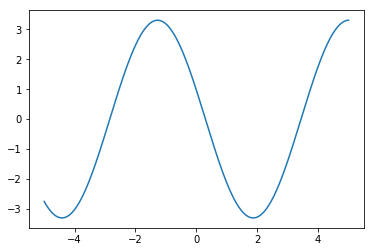

In [2]:
a = np.random.uniform(0.1, 5)
b = np.random.uniform(0, 2*np.pi)
X_plot = np.linspace(-5,5,1000)
Y = a * np.sin(X_plot + b)
plt.plot(X_plot, Y)

In [3]:
def dense_forward_norm(x,w,b, is_train, dim=None, scope=None, activation_fn=tf.nn.relu):
    h = tf.matmul(x, w) + b
    if dim is not None:
        h = tf.reshape(h, [-1, dim])
    h = tf.contrib.layers.batch_norm(h, activation_fn=activation_fn, scope=scope, reuse=tf.AUTO_REUSE, is_training=is_train)
    return h

In [4]:
def dense_forward(x,w,b, activation_fn=tf.nn.elu):
    h = tf.matmul(x, w) + b
    return activation_fn(h)

In [5]:
tf.reset_default_graph()
layers_dim = [1,64,64,1]
xavier_initializer = tf.contrib.layers.xavier_initializer()
zero_initializer = tf.zeros_initializer()
weights = [tf.get_variable('w_'+str(i), shape=layers_dim[i:i+2], initializer=xavier_initializer) for i in range(len(layers_dim) - 1)]
biases = [tf.get_variable('b_'+str(i), shape=[layers_dim[i+1]], initializer=zero_initializer) for i in range(len(layers_dim) - 1)]

In [10]:
# FOMAML

In [6]:
# MAML
UPDATED_TIMES = 32
x_train = tf.placeholder(dtype=tf.float32, shape=[None, None, 1])
x_val = tf.placeholder(dtype=tf.float32, shape=[None, None, 1])
y_train = tf.placeholder(dtype=tf.float32, shape=[None, None, 1])
y_val = tf.placeholder(dtype=tf.float32, shape=[None, None, 1])
lr1 = tf.placeholder(dtype=tf.float32)
lr2 = tf.placeholder(dtype=tf.float32)
optimizer = tf.train.AdamOptimizer(learning_rate=lr2)

def meta_step(inp):
    x_train, y_train, x_val, y_val = inp
    new_weights = [None, None, None]
    new_biases = [None, None, None]
    grads_col = []
    train_losses = []
    val_losses = []
    print(x_train, x_val)
    for i in range(UPDATED_TIMES):
        if i == 0: # First Update
            for j in range(len(layers_dim) - 1):
#                 if j == 0: hidden = dense_forward(x_train, weights[j], biases[j])
#                 elif j == len(layers_dim) - 2: train_output = dense_forward(hidden, weights[j], biases[j], lambda x:x)
#                 else: hidden = dense_forward(hidden, weights[j], biases[j])
                if j == 0: hidden = dense_forward_norm(x_train, weights[j], biases[j], True,layers_dim[j+1], str(j))
                elif j == len(layers_dim) - 2: train_output = dense_forward(hidden, weights[j], biases[j], lambda x:x)
                else: hidden = dense_forward_norm(hidden, weights[j], biases[j], True,layers_dim[j+1], str(j))
            train_loss = tf.losses.mean_squared_error(y_train, train_output)
            weights_grads = tf.gradients(train_loss, weights)
            biases_grads = tf.gradients(train_loss, biases)
            for j in range(len(layers_dim) - 1):
                new_weights[j] = weights[j] - lr1 * weights_grads[j]
                new_biases[j] = biases[j] - lr1 * biases_grads[j]
                print(new_weights[j])

        else:
            for j in range(len(layers_dim) - 1):
#                 if j == 0: hidden = dense_forward(x_train, new_weights[j], new_biases[j])
#                 elif j == len(layers_dim) - 2: train_output = dense_forward(hidden, new_weights[j], new_biases[j], lambda x:x)
#                 else: hidden = dense_forward(hidden, new_weights[j], new_biases[j])
                if j == 0: hidden = dense_forward_norm(x_train, new_weights[j], new_biases[j], True,layers_dim[j+1], str(j))
                elif j == len(layers_dim) - 2: train_output = dense_forward(hidden, new_weights[j], new_biases[j], lambda x:x)
                else: hidden = dense_forward_norm(hidden, new_weights[j], new_biases[j], True,layers_dim[j+1], str(j))
            train_loss = tf.losses.mean_squared_error(y_train, train_output)
            weights_grads = tf.gradients(train_loss, new_weights)
            biases_grads = tf.gradients(train_loss, new_biases)
            for j in range(len(layers_dim) - 1):
                new_weights[j] = new_weights[j] - lr1 * weights_grads[j]
                new_biases[j] = new_biases[j] - lr1 * biases_grads[j]
        print(i)
        for j in range(len(layers_dim) - 1):
#             if j == 0: hidden = dense_forward(x_val, new_weights[j], new_biases[j])
#             elif j == len(layers_dim) - 2: val_output = dense_forward(hidden, new_weights[j], new_biases[j], lambda x:x)
#             else: hidden = dense_forward(hidden, new_weights[j], new_biases[j])
            if j == 0: hidden = dense_forward_norm(x_val, new_weights[j], new_biases[j], True,layers_dim[j+1], str(j))
            elif j == len(layers_dim) - 2: val_output = dense_forward(hidden, new_weights[j], new_biases[j], lambda x:x)
            else: hidden = dense_forward_norm(hidden, new_weights[j], new_biases[j], True,layers_dim[j+1], str(j))
                
        val_loss = tf.losses.mean_squared_error(y_val, val_output)
        print(val_loss)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        grads_col.append((weights_grads, biases_grads))
        
    return [train_losses, val_losses, train_output, val_output]

# for j in range(len(layers_dim) - 1):
#     if j == 0: hidden = dense_forward(x_val, new_weights[j], new_biases[j])
#     elif j == len(layers_dim) - 2: hidden = dense_forward(hidden, new_weights[j], new_biases[j], lambda x:x)
#     else: hidden = dense_forward(hidden, new_weights[j], new_biases[j])

output_dtype = [[tf.float32] * UPDATED_TIMES, [tf.float32] * UPDATED_TIMES, 
                tf.float32, tf.float32]
results = tf.map_fn(meta_step,
           elems=(x_train, y_train,
                  x_val, y_val),
           dtype=output_dtype, parallel_iterations=4)
train_losses, val_losses, train_output, val_output = results
        
batch_norm_updater = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
updater = optimizer.minimize(val_losses[-1])
# updater = tf.group([optimizer.minimize(val_losses[-1]), batch_norm_updater])

Tensor("map/while/TensorArrayReadV3:0", shape=(?, 1), dtype=float32) Tensor("map/while/TensorArrayReadV3_2:0", shape=(?, 1), dtype=float32)
Tensor("map/while/sub:0", dtype=float32)
Tensor("map/while/sub_2:0", dtype=float32)
Tensor("map/while/sub_4:0", dtype=float32)
0
Tensor("map/while/mean_squared_error_1/value:0", shape=(), dtype=float32)
1
Tensor("map/while/mean_squared_error_3/value:0", shape=(), dtype=float32)
2
Tensor("map/while/mean_squared_error_5/value:0", shape=(), dtype=float32)
3
Tensor("map/while/mean_squared_error_7/value:0", shape=(), dtype=float32)
4
Tensor("map/while/mean_squared_error_9/value:0", shape=(), dtype=float32)
5
Tensor("map/while/mean_squared_error_11/value:0", shape=(), dtype=float32)
6
Tensor("map/while/mean_squared_error_13/value:0", shape=(), dtype=float32)
7
Tensor("map/while/mean_squared_error_15/value:0", shape=(), dtype=float32)
8
Tensor("map/while/mean_squared_error_17/value:0", shape=(), dtype=float32)
9
Tensor("map/while/mean_squared_error_19/val

In [7]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [8]:
saver = tf.train.Saver()

In [9]:
saver.restore(sess, "model/checkpoint-19-3-3/model.ckpt")

INFO:tensorflow:Restoring parameters from model/checkpoint-19-3-3/model.ckpt


In [29]:
# Training Loop
SAMPLES = 50000
X_val = np.expand_dims(np.array([np.linspace(-5,5,100)] * 20), axis=-1)
loss_history = []

for i in range(SAMPLES):
    a = np.random.uniform(0.1, 5, size=(20,1,1))
    b = np.random.uniform(0, 2*np.pi, size=(20,1,1))
    X_train = np.random.uniform(-5,5, size=(20,20,1))
    Y_train = a * np.sin(X_train + b)
    Y_val = a * np.sin(X_val + b)
    feed_dict = {
        x_train: X_train,
        x_val: X_val,
        y_train: Y_train,
        y_val: Y_val,
        lr1: 1e-2,
        lr2: 1e-3    
    }
    losses, _, show_loss = sess.run([val_losses, updater, val_losses[-1]], feed_dict=feed_dict)
    loss_history.append(show_loss)
    print('Sample {} - loss: {}'.format(i, show_loss))
    if i % 100 == 0:
        save_path = saver.save(sess, "model/checkpoint-19-3-4/model.ckpt")
        print("Model saved in path: %s" % save_path)
    

Sample 0 - loss: [2.0135996e+00 7.3096394e-03 2.4874690e+00 9.9875204e-02 4.6862831e+00
 2.1415210e+00 1.0844632e-01 2.1696241e+00 1.5624601e+00 8.9807069e-01
 4.0936196e-01 2.7065931e-02 3.0654931e+00 3.0974927e+00 1.9968921e-01
 1.1560619e+00 4.5893257e-03 8.6159334e+00 2.2153981e+00 6.2890391e+00]
Model saved in path: model/checkpoint-19-3-4/model.ckpt
Sample 1 - loss: [6.3613267  3.7910213  0.13219537 0.10725651 7.149675   0.4855345
 0.4331579  3.545627   4.1066637  0.8747763  0.38760808 0.06565659
 0.75741106 4.6355634  0.7953496  1.8693628  0.0938921  4.869236
 0.77153313 2.1447437 ]
Sample 2 - loss: [0.1003191  3.4175005  0.01409055 0.11162789 0.54538256 0.03488688
 0.2546662  1.8276117  0.03873603 0.25727704 0.15661183 0.3653558
 4.5339284  5.4523363  2.1286755  0.14542322 5.7174973  0.7617698
 0.20443472 1.4511282 ]
Sample 3 - loss: [0.5102977  1.0627319  7.948547   0.15802878 0.5636515  5.9663887
 0.4482546  4.717919   2.1986687  0.18562385 0.2238172  0.00804865
 0.01925392 0

 2.1466985  1.6710695 ]
Sample 33 - loss: [1.3403964e+00 1.3829552e+00 1.7191406e+00 2.1255236e+00 8.9546704e-01
 2.6689787e+00 4.3325741e-03 1.5608068e+00 8.0917376e-01 5.1460117e-01
 1.0421842e-01 1.5136811e+00 1.2143483e+00 1.0780945e-01 1.8435587e+00
 5.0650864e+00 8.5383244e-02 3.3103914e+00 1.7836549e+00 1.8218864e+00]
Sample 34 - loss: [3.49424928e-02 6.66987747e-02 1.03834264e-01 8.69454980e-01
 8.31706905e+00 1.39513493e-01 9.15531635e-01 2.81120446e-02
 5.69715559e-01 2.50858736e+00 5.48169315e-01 2.74595648e-01
 3.37090611e-01 4.53340578e+00 2.09808201e-01 1.14320374e+00
 3.13402474e-01 4.04267168e+00 4.45231348e-02 4.81941365e-03]
Sample 35 - loss: [1.0889816  0.04685619 0.01082109 1.3290519  3.2720475  0.9023987
 0.9843135  2.202472   0.024243   1.7145662  0.00966084 0.84207314
 0.04689673 0.27721146 3.6931326  0.12560318 1.444204   0.7900019
 0.5561975  4.355124  ]
Sample 36 - loss: [3.5654831e-01 9.2322177e-01 1.8199350e+00 4.5653220e-02 2.1235602e+00
 5.7679081e-01 3.48

 0.13433349 0.34041435]
Sample 65 - loss: [1.070931   3.0995944  1.5932968  1.0885016  0.7352426  2.4374998
 0.49567947 1.9376266  0.71706337 0.17026779 2.3257601  4.370506
 0.2197151  0.66075975 2.3633418  2.1584198  0.25882787 0.10999287
 1.4425801  0.25628766]
Sample 66 - loss: [1.287692   4.829306   0.54715574 7.2832265  0.20711029 0.18577126
 0.4858786  0.01695504 0.4731327  0.48508957 2.1586795  1.9478519
 0.2903819  0.01066993 0.21646968 0.56434727 1.4504416  0.07557512
 0.03892967 0.15825923]
Sample 67 - loss: [5.0452776  0.39972138 0.39925238 1.2480904  0.11503194 3.2066858
 0.4357645  0.18422554 0.80848587 0.21452585 0.8197844  0.9774231
 3.187054   0.774823   0.217399   0.6151045  0.3693647  3.99099
 2.874632   1.3950549 ]
Sample 68 - loss: [0.05284003 0.47259444 7.5999756  0.4528024  0.3865283  3.4593253
 0.58090496 1.930681   0.03524159 1.0209081  0.13795711 0.75090677
 8.558706   2.6591318  0.151981   4.342806   1.0731006  4.307431
 2.8218167  1.0697069 ]
Sample 69 - loss

 1.9444451  0.11927413]
Sample 98 - loss: [0.15418896 0.27612722 0.7371757  0.01345586 0.03888568 0.93211263
 0.5077235  2.1640868  3.426881   0.04263581 2.8042092  2.5212147
 0.49457172 0.15629306 0.399039   7.2710085  0.04375259 0.07844815
 0.0174494  0.22902298]
Sample 99 - loss: [1.9990644  1.6477673  0.04365148 0.26662543 4.6384773  0.0684688
 0.12126895 0.32264793 0.6758759  0.7496923  1.2234459  2.7001176
 0.17735843 0.57525843 0.11837766 1.1757245  0.683888   0.41692483
 3.326611   0.751959  ]
Sample 100 - loss: [ 0.96578     0.42794633  3.1489103   0.6524844   3.4518871   2.1817255
  0.8074523   0.2751138   0.01618335  2.3907678   0.02993801  1.3805876
  6.543555    0.727627    0.01818937  1.6549432  10.058309    1.2643428
  0.75920296  2.1578057 ]
Model saved in path: model/checkpoint-19-3-4/model.ckpt
Sample 101 - loss: [0.49120972 1.8827716  0.16178828 0.07541794 2.4465525  0.0310578
 3.6776447  0.4667194  0.125989   2.4718187  0.43094617 0.17166997
 1.1304915  0.4375715  0

 2.8553944e+00 4.7254515e+00 1.5386861e-02 2.6989188e+00 1.7378025e-01]
Sample 130 - loss: [6.7942076  1.6904619  4.2597747  0.99076265 1.0957304  0.16282393
 6.222994   7.391732   2.1716301  0.63215125 1.2670884  2.3858786
 0.8965756  4.370395   4.879836   5.362113   2.636564   0.8105534
 0.04266878 3.6493578 ]
Sample 131 - loss: [2.7995865e+00 9.4929689e-01 1.7590541e+00 1.7091476e+01 2.0271592e+00
 2.6692989e-01 4.7703016e-01 1.0547522e+00 9.1448611e-01 2.1695029e-02
 4.3581184e-02 1.7066132e+00 2.1632180e+00 9.4398167e-03 2.0278618e-01
 7.3474222e-01 2.6785314e+00 5.4589214e+00 6.8173438e-02 1.1349251e+00]
Sample 132 - loss: [1.5990452  0.03035954 0.02278415 1.6721077  0.01921275 1.8075726
 1.9172314  1.7418969  0.01601223 0.68024004 0.39469683 0.4322432
 0.9168973  0.45075455 0.63408756 3.6364257  0.15127988 0.02777749
 0.25855994 0.24993533]
Sample 133 - loss: [ 0.62186635  0.18004288  4.0857253  19.026009    0.793896    0.42639914
  0.05173378  7.5971336   5.762418    1.0954968 

 0.28431314 6.3502345 ]
Sample 163 - loss: [0.03022855 2.944981   0.17062312 0.49278793 1.4116204  5.382048
 3.319492   0.30530933 0.17376442 2.2384896  2.6966279  5.9944057
 2.273414   5.5498643  2.8446455  0.6169138  1.4668454  0.03923921
 3.0135052  1.4978192 ]
Sample 164 - loss: [0.15097049 0.9658139  3.574974   0.9173199  1.9051405  3.3532517
 0.00717494 0.0782894  0.45756522 1.8417548  0.02104136 0.00945348
 1.3827193  5.3636823  1.6861136  1.3089641  1.6670536  1.5675884
 1.2928967  1.9735385 ]
Sample 165 - loss: [0.01030097 0.94971687 4.5041647  9.061381   0.2845826  0.0102229
 0.65513283 0.0181617  3.3301902  0.02606989 0.23405857 0.47080994
 1.0784025  0.9171481  2.0630414  0.99809146 7.9946423  0.40743825
 0.25080985 0.0497745 ]
Sample 166 - loss: [ 1.7384948   0.9911611   0.32390323  3.4679267   0.9190797   0.11051839
  8.587058    0.14735568  0.8465171   0.12858962  0.09553649  0.43724376
 12.045889    0.04997165  0.28540987  0.95578253  3.9655762   4.8107796
  0.5388968  

 3.32477182e-01 1.28151143e+00 1.40666342e+00 1.50412595e+00]
Sample 197 - loss: [1.9783823e-02 1.3272063e-02 1.1363351e+00 5.3548086e-02 8.1846088e-02
 1.1583897e+00 5.4225655e+00 6.6321020e+00 1.0894540e+01 6.7327803e-01
 8.1142597e+00 4.7604445e-02 7.8321230e-01 5.2320544e-02 1.1249048e+00
 1.1400515e-01 1.5697078e-01 5.8236226e-02 1.0031877e+00 6.6669434e-03]
Sample 198 - loss: [0.01021149 0.41754967 4.1682277  1.9042512  1.6801081  1.9769454
 0.01654186 3.5651531  1.8385131  0.17437622 0.06274374 2.067021
 0.02060809 1.63735    0.32735962 0.53164685 3.2601755  2.8461804
 1.6443819  1.2093536 ]
Sample 199 - loss: [1.1402171e+00 3.7709212e-01 2.2250561e+01 3.0634303e-02 1.6459760e-01
 8.8400133e-02 7.8287101e-01 5.2398461e-01 1.9961491e-02 1.3052346e-01
 1.6468109e-01 1.8938388e+00 2.6385300e-02 6.4297826e-03 1.0717064e+00
 6.2618233e-02 2.8468546e-01 1.0521422e-01 4.2111073e+00 4.2715611e+00]
Sample 200 - loss: [4.747809   0.409341   2.2612586  8.319423   0.02743972 1.5058266
 0.87

 0.00839574 0.01135938]
Sample 229 - loss: [6.46679    3.3687124  0.05417417 3.7208495  0.06943478 0.8574285
 0.63275605 0.8612376  0.3774556  0.031179   1.7954891  2.8197525
 1.2292877  5.5742126  0.53249764 2.4132545  3.1157122  2.6206388
 9.105209   0.4484746 ]
Sample 230 - loss: [0.63936514 4.6080527  0.29848874 0.8849713  0.03626346 1.9211392
 0.11497509 0.01332472 0.22495322 1.7935262  4.1692944  3.5299964
 0.20120949 1.6169586  2.2967062  0.03506052 3.5873377  1.7850467
 0.72325784 1.1335851 ]
Sample 231 - loss: [0.20065749 1.1578641  0.00900748 1.776577   0.06440796 0.8468144
 0.07961971 0.06688008 0.3203975  4.2939434  0.62644666 1.5842029
 4.116788   1.3973039  0.7123415  7.5892653  0.34255418 0.5607576
 0.01742678 0.2561734 ]
Sample 232 - loss: [ 0.58689165  1.6958051   4.9049916  13.67624     0.41234955 11.194982
  0.5034077  10.628279    0.866724    2.0556784   1.7055409   1.3121407
  0.04205251  0.4484025   2.9972906   4.430172    0.55757034  3.414065
  1.539281    0.1449

 0.82655644 1.4986434 ]
Sample 263 - loss: [0.06750123 0.3204586  0.09029188 0.06711066 3.0920355  1.4970443
 0.28495425 0.30528754 1.8596013  3.3854265  0.5847564  0.21308504
 0.28237647 0.07933419 1.4908628  3.165285   1.2144448  0.39044872
 6.2164216  0.50413126]
Sample 264 - loss: [0.21944886 0.01570717 4.067075   1.0877377  0.24519995 0.1757634
 6.6576824  0.04132662 2.5477896  1.0176293  2.93051    0.7061872
 5.8582363  0.03019474 0.33381185 0.08833705 1.8569729  1.3202162
 0.19424985 0.6537465 ]
Sample 265 - loss: [1.6773376  0.61882544 0.63406134 0.48344955 1.2894697  2.552079
 2.0212564  0.1093215  0.22580431 0.02219827 0.01640406 1.1952478
 1.1402185  0.683664   0.49873    0.7084151  1.3057922  3.1358073
 0.14198114 0.11329379]
Sample 266 - loss: [0.60373276 0.05761421 0.33446506 2.3106627  0.36409047 1.7257863
 0.02946971 3.115814   0.6013852  2.4639783  4.8225307  4.092254
 0.39116699 0.0184658  1.7546332  0.04257255 2.2440994  2.2609634
 6.1153283  0.72082543]
Sample 267 -

  3.9452033   0.98886853]
Sample 296 - loss: [6.3408756  2.0259004  3.4039395  0.04462497 0.12213915 0.10648748
 1.3502737  1.970065   1.3010907  0.04176033 1.0705358  5.6999373
 0.49745822 0.40364665 5.599552   0.47231972 0.1038571  0.27517173
 0.7119051  0.06000261]
Sample 297 - loss: [3.347291   0.32379255 2.578696   0.01285779 0.06606117 7.4038973
 2.007748   0.3414574  0.53880864 0.07357949 3.4270623  0.02288942
 0.1667813  0.64214814 0.2164742  1.251899   0.06275862 0.28926286
 2.9850886  1.3273662 ]
Sample 298 - loss: [4.21588    0.2514302  0.01766516 0.40006614 5.8677473  1.7372583
 0.31293628 1.4488821  0.23470388 0.2357611  5.9912276  0.51950336
 0.94289666 0.40459955 0.13217935 3.7096927  0.83125603 1.6958225
 0.10174673 0.06637044]
Sample 299 - loss: [2.1582286  4.801105   0.64056486 0.47561902 2.6463623  3.1152368
 2.197716   0.08381858 0.17796192 0.11367539 1.3382981  0.1481289
 0.00947467 1.8761928  0.25675055 1.171097   0.33677933 0.35051736
 0.01198771 0.06286947]
Samp

 0.01431291 1.2642434 ]
Sample 329 - loss: [2.2265608  0.32032028 5.2128253  3.8818357  0.598625   0.25826392
 6.440163   0.9728378  0.40596256 1.0414357  0.02875706 0.01324867
 1.2124562  0.04589803 4.0940824  0.17129177 1.0254221  2.9282632
 3.0239325  1.1424717 ]
Sample 330 - loss: [0.6522669  0.18006054 0.12825543 1.4226569  1.7765737  6.14891
 0.11444565 8.57342    1.47155    0.11105313 3.7077048  0.02695392
 1.8109096  0.02312729 4.4657187  3.2861729  0.16986983 0.97863525
 0.4147461  2.3813539 ]
Sample 331 - loss: [0.7082939  1.8966238  1.5335488  1.2176361  0.12880829 1.1725826
 4.949809   3.0649753  1.0838336  1.7404976  0.0861323  0.02842099
 4.400472   0.06455601 0.27454644 1.6734684  0.8520747  0.84270185
 0.08403166 0.33523244]
Sample 332 - loss: [0.00916074 4.3581896  0.05443963 6.756256   5.256295   0.24980661
 0.03431705 0.26298484 1.0882196  0.87166643 0.15801756 0.3111564
 0.487011   0.12763062 0.5452624  1.9417138  3.4388523  0.2791414
 4.164495   6.7298055 ]
Sample 

 0.01306081 0.9645918 ]
Sample 362 - loss: [9.4830437e+00 3.1105775e-01 1.4913537e-01 6.7689936e-03 1.0356739e-01
 1.4800224e+00 1.1538742e+00 2.7527397e+00 8.7057841e-01 3.3032626e-01
 3.3927343e+00 1.6911223e+00 2.2386167e+00 1.5397859e-01 2.0454673e-02
 3.7082008e-01 5.3146303e-01 1.8259134e-02 3.1340244e-01 1.0525647e+00]
Sample 363 - loss: [4.5318995  0.8166708  5.87811    1.1775422  0.08166841 0.1838625
 0.01207337 0.21531753 0.21542758 1.6695061  1.170079   0.93819976
 3.3387334  0.12568483 0.6417179  6.4662066  0.86011934 5.0020986
 2.633927   2.4301717 ]
Sample 364 - loss: [0.02461969 2.696288   1.1237348  0.68376887 0.9965912  0.51090115
 2.2329788  0.51232374 0.41663188 0.89614165 0.6946987  1.8921428
 1.2199239  0.3110681  0.560672   0.98110884 0.07208173 1.5595169
 0.2235511  0.27420735]
Sample 365 - loss: [0.5543875  0.03708901 3.6178248  0.06983986 0.23800117 2.1709244
 0.06985883 0.41171238 0.8200512  0.78617215 0.10117418 4.518488
 2.9457514  3.609143   0.02793618 0.30

 1.2601564  2.121487  ]
Sample 393 - loss: [2.1264027e-01 1.6003437e+01 5.7959189e-03 4.1349918e-02 3.1650410e+00
 1.1483258e+00 1.4778060e+00 3.3729138e+00 1.6091620e+00 6.1602248e-03
 9.9453993e+00 4.2220664e+00 1.3423990e+00 3.2234824e-01 2.8821808e-01
 5.5662880e+00 4.0592527e+00 3.1519943e-01 1.3107723e-01 1.8281150e+00]
Sample 394 - loss: [0.17676878 6.4138975  0.03426613 0.467326   2.1829536  0.01064031
 1.2978891  0.01397435 1.7449813  1.0376287  1.5035567  0.16687633
 2.1817124  1.1368608  4.1370625  0.06536783 4.275899   0.35209543
 0.05484439 8.223166  ]
Sample 395 - loss: [5.3646264  5.0962787  3.688433   4.482665   0.87658    0.11263279
 2.4990206  0.2509046  0.24456644 0.05981683 0.68669134 2.1611235
 0.05130896 4.337873   0.91293573 2.7248335  0.07558646 1.7310683
 0.8439801  0.9187554 ]
Sample 396 - loss: [0.05159647 0.04061621 2.4502757  0.45274112 1.2223305  0.31213963
 0.08743729 1.37072    0.20709337 0.7754095  0.35068718 3.5269747
 0.02407319 1.9259605  0.09395    

 3.2186692  1.9757745 ]
Sample 426 - loss: [0.5316803  0.03401164 1.2457705  0.29070997 0.52122027 0.5357955
 0.05109641 1.9748216  9.629659   2.0510995  0.28342006 0.02373714
 1.6372833  0.09966881 6.968584   0.40822795 0.85163903 1.0909706
 0.5799115  2.3338606 ]
Sample 427 - loss: [ 0.22944088  7.495303    7.0783887   1.1132631   0.4170792   1.296416
  1.2717365   0.7984129   6.5358543   0.04280495  0.30549863  0.41009864
  1.6797204   0.77144927  1.2053186   0.6354137   1.4744164  12.116075
  2.5438337   4.6990466 ]
Sample 428 - loss: [6.1516666  0.08633568 2.2546072  1.8627717  0.21547051 0.2968384
 2.1460972  1.0210603  0.134326   0.10886343 0.04468019 0.08921487
 3.7742667  0.4521216  0.01973212 5.608285   0.22778589 8.244304
 0.01194066 4.308605  ]
Sample 429 - loss: [0.12301534 3.841892   1.6733054  0.13091797 1.8133171  0.70818824
 0.16132836 3.4766586  0.0243149  0.13820666 1.298378   0.5985435
 0.17862369 4.04591    3.9528856  1.5602084  3.761621   0.45031226
 1.1608297  1.

 0.00954084 0.13678373]
Sample 459 - loss: [1.0300915  0.04763159 0.02007954 0.24786887 0.36843216 0.19750555
 3.23693    0.310582   0.16336891 0.91422045 1.4523906  0.1930677
 3.3113952  0.29509425 0.65633035 0.5083669  0.600765   0.05875259
 0.14417382 0.02503538]
Sample 460 - loss: [0.4135535  7.4851537  3.1421878  0.68117654 0.9811913  0.7773722
 3.728944   0.01303227 0.17131467 0.11258212 0.20972899 3.566367
 0.27709273 4.3991528  0.03044914 0.19035406 2.2803557  0.25075296
 0.0605443  0.78704715]
Sample 461 - loss: [0.01412947 0.7371392  5.0104775  3.612197   0.50947714 0.03749948
 1.7022538  3.4618168  3.5032575  0.05976344 1.0872486  2.2772615
 0.3804159  2.061083   0.40776637 0.64603394 4.7846966  0.2954666
 7.626715   0.75717443]
Sample 462 - loss: [4.2086235e-01 2.4714254e-01 1.5598406e+00 7.6649265e+00 1.8049222e+00
 4.5900717e-01 2.6870662e-01 1.6583502e+00 1.8008310e+00 2.6795053e+00
 1.1231445e+00 5.5393000e+00 2.9835308e-01 1.4234295e-01 8.8772172e-01
 7.5430598e+00 1.4

 0.00391976 2.0674086 ]
Sample 491 - loss: [0.28510496 4.1128526  0.01247719 2.3491733  1.5521882  0.13336661
 0.87804407 0.07428494 0.6490598  0.8168228  1.5707241  0.14087763
 0.43918267 0.33943096 0.572204   8.338123   0.40455663 0.08123793
 3.2966971  1.5498493 ]
Sample 492 - loss: [1.3751949  1.9016657  0.13844706 0.129968   5.3002596  1.2848036
 0.8344476  0.04801562 5.805727   0.3354895  0.08245189 0.66963446
 2.5382862  1.1264666  0.01902257 2.2166522  0.71764755 0.67380023
 2.9885175  0.63942426]
Sample 493 - loss: [0.4519152  4.7469215  0.24840923 2.1804094  0.05893731 0.1135857
 6.3447247  1.2838647  4.067546   0.19180271 0.04985537 2.5153515
 0.685049   1.27636    0.06240289 0.95719415 9.840912   0.22593682
 0.37216213 0.01521032]
Sample 494 - loss: [2.422227   4.1743126  0.78195363 0.6527323  5.1817884  0.7739589
 3.0873873  0.70065385 0.35052037 0.26524094 0.63049066 1.5329763
 5.255498   1.5578821  2.8411996  0.03910494 0.85548866 0.01385139
 9.569856   0.5335019 ]
Sampl

 6.1176568e-01 3.5974150e+00 7.0456070e-01 1.9477829e-01 1.2578605e+00]
Sample 523 - loss: [0.7343777  1.8644235  0.35373247 0.13770251 0.02288264 0.12216986
 0.6088298  0.05031214 7.764392   5.828666   0.7096703  0.7877862
 0.4021131  0.30418855 1.4872351  2.0111482  0.10889611 0.02926763
 0.658329   5.4007816 ]
Sample 524 - loss: [0.38786972 0.01348735 2.0273347  6.9131336  0.9676063  6.512432
 1.5847703  0.05728148 0.3130083  0.4894592  1.4439756  0.71406144
 0.09526289 0.5519767  1.2917566  0.97905576 0.02400073 0.86543006
 0.03676332 0.9729807 ]
Sample 525 - loss: [0.1460608  0.01531121 5.535256   2.9508688  1.7006259  0.23522381
 1.2079439  0.5166212  5.8799267  0.15285327 3.3729742  1.8762751
 2.3192651  6.6291413  0.14693432 0.13603666 1.5201595  7.4692235
 0.49311528 0.16053337]
Sample 526 - loss: [1.1682652  0.6349202  0.29459786 0.5437443  7.023167   1.8113418
 1.245761   0.22478648 4.0488925  0.38891926 0.08404306 3.8941042
 0.0083855  0.06878974 0.2940849  0.02381943 0.113

  0.20209518  1.0580887 ]
Sample 555 - loss: [0.7753004  0.02520739 1.1411397  5.4392185  0.82261175 5.921615
 0.88396126 0.10541115 0.6903761  2.4963365  3.9378462  1.1786801
 0.31037498 0.06225872 1.874048   2.0894966  0.580482   3.624831
 3.9631228  0.15480687]
Sample 556 - loss: [2.7049987  0.39477637 1.4190347  0.0038705  1.1058775  0.04804211
 2.1142664  3.4265428  0.2470462  2.5655732  0.0635567  0.04121601
 0.27291158 2.0436027  1.5786183  1.2659198  0.01484035 0.21609001
 0.82644916 2.4606004 ]
Sample 557 - loss: [ 0.10217874  1.6044458   2.4713292   6.266218    4.1916356  10.431092
  0.7375835   3.7180111   9.693555    1.2919582   0.15369573  0.41231248
  0.12531005  0.41041288  1.3605545   0.01512214  0.66190875  4.8663855
  1.211341    0.9519561 ]
Sample 558 - loss: [0.30101222 0.42904672 1.7709562  0.44584906 0.1537366  0.06520483
 1.4370807  1.5678029  0.32103214 0.12289479 1.2549465  4.275908
 3.3732166  0.02567426 0.708303   1.1847601  0.04105261 0.00950124
 1.1073024  

 0.08038532 0.09312167]
Sample 587 - loss: [3.9237118  0.26276278 1.6231762  0.21755514 0.3620052  0.8211427
 0.9740009  0.90787536 0.55386466 0.1308917  3.5803351  0.03898627
 0.73810065 1.4784688  0.19884636 0.96277124 0.24510269 0.05822252
 2.198243   4.5765343 ]
Sample 588 - loss: [0.03183153 0.45591873 0.09549441 0.06982285 2.650487   5.403104
 0.59813136 0.93599075 0.40185666 0.1193877  0.39435253 0.9770811
 1.5576478  1.5210751  0.49204648 0.04975818 4.843136   3.1294847
 4.342189   2.010003  ]
Sample 589 - loss: [0.01159231 1.4359207  5.984648   0.99494505 1.1315843  0.17888771
 0.5624057  0.01045579 3.107667   0.92633677 0.1480148  1.4658983
 2.4191313  0.5181305  3.3654099  0.10152157 1.1054012  0.43316227
 3.150396   0.07596493]
Sample 590 - loss: [0.04981577 1.2080338  0.11783436 0.39910465 1.0246047  0.27910703
 1.5280446  0.38395128 0.00495668 0.7126355  0.05234117 0.15120295
 0.160956   0.6847126  0.17990847 1.2684566  0.5533817  0.19377278
 4.4949656  2.071901  ]
Sample

  2.5431406   2.0587351 ]
Sample 620 - loss: [6.5908937e+00 1.1617885e+00 4.3587117e+00 2.0474405e+00 6.5217488e-03
 7.5743566e+00 1.2180920e-02 3.1728392e+00 2.0457405e-01 5.7789755e-01
 6.5899867e-01 4.5655202e-02 1.2878598e+00 1.3407153e-01 1.3275303e-01
 3.8444653e+00 5.7314215e+00 7.2619718e-01 1.1070646e+00 2.3233163e-01]
Sample 621 - loss: [ 3.5441473   0.09297688  0.17405088  5.335452    2.6181169   1.1322488
  5.724099    1.4116789   0.02017048  0.08866137  0.60992885  0.05783936
  3.4116855   0.9519922   0.35648507  0.02821716  2.413952   11.381545
  1.5686258   1.4901092 ]
Sample 622 - loss: [ 1.0871718   0.01331396  6.1037807   1.177959    1.4387898   0.86827385
  0.11970752  0.11493219  0.19753277  7.064896    3.3814402   4.239976
 11.542907    0.05964519  0.07523093  0.25300187  0.05168154  0.51773924
  0.08387109  0.9028757 ]
Sample 623 - loss: [2.4867992e-01 1.5681446e+00 2.3289983e+00 3.9559271e+00 2.8542596e-01
 1.1000617e+00 2.3173018e+00 1.0223663e+00 2.8885463e-01 

 5.5511403  4.723592  ]
Sample 652 - loss: [4.5734325e-01 1.2306538e-01 4.8743984e-01 2.3848917e+00 1.8918707e+00
 1.2237550e+00 1.3016623e+00 4.1066494e-02 6.4894652e-01 1.1865815e+00
 1.2877861e+00 1.6380785e-01 2.7809095e+00 1.1005077e-02 7.5683993e-01
 8.3961744e+00 1.6876693e-01 2.0245080e+00 1.8065561e+00 6.0443594e-03]
Sample 653 - loss: [2.6804502  0.01007514 0.8994377  0.767734   0.4012257  1.492681
 0.57312024 0.05401659 0.15688951 1.3832519  0.06242057 0.3194094
 6.691555   0.15204158 3.75007    0.5700178  0.10424601 0.83432806
 0.53911203 0.11266496]
Sample 654 - loss: [0.46488884 0.00796138 0.38159135 0.00811123 3.3549585  1.8577788
 1.1137384  0.0091034  0.0946614  0.8026286  1.0772802  0.03210672
 3.8064654  1.478071   4.0827174  0.100687   0.6322938  7.414497
 0.02199995 2.2640183 ]
Sample 655 - loss: [1.8832561  2.7573512  0.75292933 1.6503155  0.26976463 0.0852878
 0.00894378 1.2402436  0.10609272 0.21553837 3.2870734  1.737287
 0.0258176  0.37339514 0.29775998 0.5805

 0.71021426 1.8886359 ]
Sample 685 - loss: [2.6132221  0.02551926 0.3472693  0.33580014 0.42990685 1.5957956
 0.37836847 0.0075762  0.07467543 0.07178418 0.9953801  0.2693361
 1.1853207  1.1867557  2.866682   0.27907196 2.081226   0.03832847
 0.8383524  2.270643  ]
Sample 686 - loss: [6.97816491e-01 1.81468534e+00 3.75680961e-02 4.68134731e-02
 1.28344905e+00 2.54242420e+00 1.06329596e+00 3.62694097e+00
 4.02509391e-01 7.88005304e+00 1.83125019e+00 6.21481100e-03
 3.74092944e-02 1.57403839e+00 2.90534329e-02 1.03453435e-01
 5.20738649e+00 2.59365439e-01 4.33490133e+00 1.01378417e+00]
Sample 687 - loss: [0.31928653 0.03453922 1.1651447  0.04474202 0.9510739  2.4022114
 0.96255875 2.0446258  0.25177655 0.07460833 0.42448547 0.203498
 0.00565928 0.02260603 0.30667624 1.257706   0.04723877 0.02140195
 1.8777581  0.52265084]
Sample 688 - loss: [2.5017786  3.311368   0.95797765 3.3628368  0.02975795 0.40439183
 0.61818945 5.7690783  0.10718467 1.0966268  1.9615488  6.103162
 1.4679427  0.394

 1.486473   0.21747549]
Sample 716 - loss: [1.1164148e-01 1.8569601e-01 4.9054481e-02 9.7923207e-01 5.3157538e-01
 1.1804777e+00 4.5216188e-01 5.5811840e-01 4.4913948e-01 4.0194738e-01
 5.6563252e-01 9.9199188e-01 1.2291892e-02 3.8243240e-01 1.2480749e+00
 1.3174767e+01 1.8908330e+00 1.9742627e+00 2.8455949e+00 9.2743182e-01]
Sample 717 - loss: [1.2615124e-02 4.9818081e-01 2.8209341e+00 5.1562638e+00 1.0695468e-01
 2.9662734e-01 2.3639429e+00 1.0685757e+00 9.9440575e-01 2.7201211e-02
 1.3199182e-01 3.0030644e-02 5.4791947e-03 1.0714456e+01 1.9670537e-02
 4.5071507e+00 1.9213764e-01 6.2904650e-01 3.3674498e+00 4.3348827e+00]
Sample 718 - loss: [1.5341556e+01 4.9601231e-02 5.7777917e-01 2.1023874e-01 1.0901738e-01
 1.9991975e+00 9.3018240e-01 5.0671738e-01 4.8814712e+00 6.4533501e+00
 4.1494048e-01 9.1367904e-03 3.9858440e-01 4.4745108e-01 3.3620843e-01
 2.0864443e-01 8.9652594e-03 3.7554574e+00 2.5822710e-02 7.1623311e-03]
Sample 719 - loss: [0.01116427 5.055132   1.0948619  0.5231929  

 0.01102811 4.3819823 ]
Sample 747 - loss: [0.15168883 0.06894625 0.5026673  2.8510673  1.4194545  1.5589592
 0.58586335 1.2505903  0.6235865  1.4946214  0.08375276 0.77018636
 0.41489536 0.13465382 0.19509785 0.07137674 1.1180546  1.799375
 0.00576244 0.07977554]
Sample 748 - loss: [0.06987537 0.14470899 0.30212    1.0859898  0.61743075 0.05288053
 0.32487047 3.6418     2.3660486  8.019004   0.19405496 1.9025959
 1.7080814  6.5586696  5.5600305  0.9923257  2.5109549  0.27149457
 1.8760628  1.7184547 ]
Sample 749 - loss: [ 7.782616   11.5439205   0.20925522  0.07474221  0.80882066  0.02210822
  0.01698527  1.359897    1.4184396   0.39604896  7.347503    5.0557857
  1.9110031   0.17011638  1.0832      0.12034266  0.95893776  1.3626502
  3.0680506   2.939782  ]
Sample 750 - loss: [1.2148962e+00 4.1418810e+00 3.2027385e-01 1.1043622e-01 2.6869541e-02
 9.2536473e-01 3.4669323e+00 1.5173665e+00 4.1278526e-03 4.1785643e-02
 9.1787621e-02 6.4263582e-02 1.9977437e+00 1.7038952e+00 7.8883737e-0

  1.761667    5.078166  ]
Sample 778 - loss: [1.0090417  0.33520615 4.8867397  0.5333801  0.05858505 0.31313124
 1.9765172  8.925177   0.2717818  1.0134661  4.9554877  1.9724355
 1.1912413  0.01861836 2.458651   0.11076413 0.09097938 0.7188159
 6.0012445  3.3565133 ]
Sample 779 - loss: [1.0042175  0.24609117 0.40332723 0.08686277 0.61583066 0.11185506
 1.5260282  0.0147458  1.2476343  0.03178845 0.13762261 1.901306
 2.2471466  0.7694672  0.29472902 0.43830574 1.0922707  0.6988656
 1.3004576  2.8951218 ]
Sample 780 - loss: [1.3323741  3.0889509  0.0776722  1.7740641  1.981829   1.1227307
 3.1215153  7.496518   3.8288746  5.6755147  0.18589008 1.5358505
 0.02579768 0.02089259 3.1592007  2.5046878  0.09581532 1.7977527
 0.57352984 0.832806  ]
Sample 781 - loss: [3.7254744  4.4536467  0.01081483 1.985661   1.1255686  0.6048747
 1.6320416  0.0544751  0.5001333  0.02908698 3.7198422  1.3651553
 1.7559333  1.0013244  0.50271297 1.3668398  0.8308996  0.10875308
 2.428551   4.177175  ]
Sample 7

 1.41735563e+01 4.99566078e+00 5.69591856e+00 5.75941764e-02]
Sample 809 - loss: [5.8520561e-01 4.9806926e-01 4.0967545e-01 4.3303914e-02 2.3911946e-01
 3.6321563e-01 2.9688135e-02 1.8401704e+00 1.4127938e-01 9.7686644e+00
 1.0563848e+00 9.7101657e-03 1.3130188e-01 4.9934464e+00 6.8763103e+00
 2.6190515e+00 4.3205798e-01 4.9370580e+00 6.1767977e-01 8.1168633e+00]
Sample 810 - loss: [ 0.12440458  3.418089    0.9467499   0.700749    1.2382193   0.4682593
  1.0236616   1.5228453   1.0204463   5.502185    0.5144078   4.471947
  2.3375285   0.03305872  0.9058184  12.370418    0.09161524  2.7336307
  0.18514967  2.285009  ]
Sample 811 - loss: [0.06527767 1.4868611  1.6889132  0.5772564  2.3137293  1.9260373
 0.07898307 1.8981118  1.2617482  2.165183   0.4211619  0.14074816
 0.3346014  0.84705234 2.0371802  0.02468663 0.2134581  0.22949053
 0.74203527 1.1292893 ]
Sample 812 - loss: [0.48569268 0.04670218 0.3191169  0.8504968  2.2151656  0.18940184
 0.5711412  0.40276647 1.1437259  0.53326654 

 0.9272673  0.03812965]
Sample 840 - loss: [0.21027674 0.86204314 1.021254   6.9494495  0.62254757 6.100767
 0.67330134 0.16912897 0.2212273  1.5301706  1.1516399  0.02449651
 0.31365314 0.876202   5.8802767  0.0969283  0.6500835  0.06034391
 2.1229467  0.75383395]
Sample 841 - loss: [0.00597041 1.1996293  0.2443317  3.1705575  0.29118955 0.5809099
 1.0276718  3.2369719  0.01715948 0.615353   0.02838033 0.4726573
 5.8506637  2.2469678  0.23092636 0.6005627  0.56561136 4.5569153
 0.270836   0.00823234]
Sample 842 - loss: [0.06357329 0.01496488 3.713595   0.9330656  0.4059135  0.9247294
 4.053125   2.517043   3.193282   1.5134424  0.6890638  0.49576172
 0.6925427  0.89573264 0.06115211 0.03085447 2.3861275  0.21619353
 1.7363334  1.8233697 ]
Sample 843 - loss: [0.36138618 3.7799845  1.6229221  0.6386037  0.16261673 0.01913853
 6.318022   0.25924203 2.2141747  0.9192047  0.55745196 0.109655
 1.5213202  3.4839404  2.4237502  0.01324168 0.22537006 4.1594224
 0.8536525  1.2137171 ]
Sample 84

 0.01821854 1.4412007 ]
Sample 872 - loss: [0.3992879  1.8163197  0.10839882 1.713656   0.01129302 2.753392
 6.0457015  7.11955    0.71441114 0.84791833 0.13181059 0.08601971
 0.74973404 0.01187406 0.31781295 1.2870462  1.6307547  3.7282987
 1.3619266  1.4309691 ]
Sample 873 - loss: [0.74574417 0.00792653 0.84783477 0.02328272 0.02478802 0.43398288
 0.330248   0.2845373  2.265953   1.4364952  0.20167318 0.36607438
 1.1897851  2.1761892  0.11603141 0.59870017 2.1152432  0.3491594
 0.3723027  0.07942164]
Sample 874 - loss: [2.1417692  0.21780026 0.6534176  1.1561532  5.423363   1.474914
 0.5314341  0.01820216 0.7367481  2.5061734  0.03664378 0.21217522
 0.00620738 0.02372552 0.510886   5.0425787  0.07648095 0.21492854
 1.7795851  3.6504655 ]
Sample 875 - loss: [1.497085   6.062271   0.210286   0.34176102 0.17544438 0.25068152
 1.216753   3.1653738  0.25432792 1.4157228  0.28092676 0.98080045
 0.01253461 1.3973306  7.951094   1.4830301  0.09204576 0.7489705
 3.88597    1.56233   ]
Sample 

 0.0418713  2.6626034 ]
Sample 904 - loss: [4.6061993  5.5269194  0.55396223 0.60103154 0.42370084 0.07945455
 0.52288836 0.0300722  0.1225775  0.7066495  1.2693502  5.895752
 0.38525754 2.5467916  0.76771677 1.1195561  0.03626452 2.4266596
 0.2573245  4.571474  ]
Sample 905 - loss: [0.22266327 0.2422863  0.0336549  0.02361906 6.1680303  0.009813
 0.11721914 1.471715   0.6706053  5.2590356  0.0426647  0.32235444
 6.3730516  1.3159859  0.51449794 8.062394   0.90358764 1.4257921
 3.056205   0.6654533 ]
Sample 906 - loss: [0.05814234 2.7941055  3.7116861  0.46961957 1.4005647  0.06989481
 0.38364357 6.276955   0.26106268 0.16868964 0.19876017 0.5017646
 0.31946722 2.6192386  0.88584006 3.2643301  0.8263743  0.18900236
 2.0811563  1.9608524 ]
Sample 907 - loss: [1.185533   1.4308797  2.4209192  1.8364242  2.1886382  1.5369736
 0.38978294 0.33424678 0.02628765 3.0016315  0.6415324  3.8154116
 0.92362875 0.72807384 0.10139316 0.01553383 0.33886325 3.7843041
 1.7883453  0.11014333]
Sample 908

 0.03562137 1.3545852 ]
Sample 936 - loss: [4.8879313  1.5122577  0.6067101  0.8189842  1.2662771  0.9665373
 5.3686023  0.11419623 3.3684058  0.6821624  0.15620293 1.4966528
 0.45801598 0.05980977 3.76487    0.9892418  0.47432762 0.64241624
 0.26276913 0.24972713]
Sample 937 - loss: [1.41032413e-01 1.42521107e+00 3.09829274e-03 1.38443875e+00
 1.36986208e+00 2.62826228e+00 1.08981311e+00 1.45973012e-01
 4.78123486e-01 2.29701087e-01 6.17792845e+00 1.17256254e-01
 5.11479139e-01 1.88043606e+00 8.60594213e-02 2.91820854e-01
 1.34325683e+00 7.81882763e-01 7.60687351e-01 2.44080257e+00]
Sample 938 - loss: [1.9464818e+00 1.6555220e-02 8.5435007e-03 2.3409939e+00 1.4824655e+00
 2.1301633e-01 6.3132839e+00 8.6881602e-01 2.1206836e-01 5.8389097e-01
 2.6865501e-02 2.6385298e+00 2.8688688e-02 7.7368963e-01 8.6713880e-02
 9.4555702e+00 3.7811357e-01 2.7200601e+00 2.0977693e+00 1.5062855e-01]
Sample 939 - loss: [0.48024875 0.51655954 0.04613856 1.4854993  0.01102211 0.0843915
 0.8141692  0.040428

 1.9304101  0.07815709]
Sample 967 - loss: [ 0.7278085   0.5168356   2.294649    0.04558051  2.1473808   1.1395199
  0.09767044  1.7815322   0.75064117 16.879759    0.351503    2.1853008
 11.774684    2.3351936   1.3866044   1.5812641   0.7680597  10.053539
  0.6660309   2.3443394 ]
Sample 968 - loss: [0.15325741 0.13570961 0.03488959 2.1786306  0.4627736  4.384466
 0.9734882  1.3027173  2.0884457  7.957753   0.5678735  0.3438225
 1.124387   6.247218   0.00917873 1.4211464  0.0165744  0.35988653
 0.9697622  2.8824296 ]
Sample 969 - loss: [0.39816788 2.1385853  2.7213945  0.31030092 3.3168192  2.3507729
 0.5901332  0.25619346 2.6126642  0.30155614 0.09675322 8.48534
 2.1595984  0.8567961  0.02451949 1.3731459  0.23789835 1.4204717
 0.13062727 0.3155259 ]
Sample 970 - loss: [ 1.5381373   0.02220846  1.4606127   0.70329195  3.7685294  11.129835
  1.6402619   7.3651414   0.07473979  0.10306501  0.07019497  0.5814484
  0.3043362   0.15299281  0.42903835 11.156869    4.5854516   1.5117651
  

 2.0785596  2.280909  ]
Sample 999 - loss: [3.179086   0.20248413 0.30862853 0.09769886 4.6727057  7.9532833
 2.228754   1.4275234  4.530046   0.62616915 1.0421462  0.9822101
 1.3954294  0.05401004 0.29330304 0.05925078 4.6773443  0.7403861
 1.974506   0.09337266]
Sample 1000 - loss: [1.5393542e-01 6.3010447e-02 6.4403517e-03 1.7222426e+00 5.5741917e-02
 4.1109134e-02 4.7616739e+00 2.5151169e+00 1.5380329e+00 4.5727534e+00
 2.2633803e+00 1.0921074e-01 6.1348975e-01 8.8269576e-02 6.7502427e+00
 8.1795985e-01 1.5011753e+00 1.5075809e-01 1.7818948e+00 1.3301371e-01]
Model saved in path: model/checkpoint-19-3-4/model.ckpt
Sample 1001 - loss: [2.83566    3.655837   0.07727544 0.36732498 0.20398298 3.1524444
 6.76178    4.791762   7.33242    0.14526904 0.16976573 0.20293015
 3.7968493  3.4805574  0.5029089  0.65566874 0.07858684 0.9324518
 0.6625927  0.01053245]
Sample 1002 - loss: [0.6019754  6.4039702  0.01696627 0.09243421 0.09989305 1.8787385
 5.4365735  0.05227119 0.80633086 1.5700943  

 4.964132   0.19599926]
Sample 1031 - loss: [0.46589744 1.6133401  0.30440217 1.9418731  0.16074072 7.9399786
 2.3203704  0.04514673 0.53634375 0.07140707 0.1665546  0.25018758
 0.18830985 0.09677591 3.523387   0.625003   4.0326166  1.5734317
 0.37709302 0.1270743 ]
Sample 1032 - loss: [0.51756823 0.8530368  1.5005194  0.8069052  0.5971092  0.0595012
 0.19282867 5.515069   4.53156    0.08519758 5.891918   0.04470326
 0.03418862 0.05149515 0.02536225 0.22576769 0.5509673  0.00648234
 0.08542971 0.04688061]
Sample 1033 - loss: [1.4723326  0.02216248 0.20496152 0.0024536  1.0991424  1.1536747
 0.10439542 0.03583845 1.1840007  0.59002775 0.2879944  2.3337007
 0.1456553  0.49027568 0.55661005 0.04488571 0.06759837 0.46963656
 2.3782446  1.1335597 ]
Sample 1034 - loss: [0.01539105 5.6298747  1.373022   1.0397563  0.09173506 6.0726976
 1.7125858  0.18159753 1.3997914  4.6182785  0.09404597 0.10206421
 0.8579279  0.09103135 0.5835308  0.01899193 2.423594   4.3548894
 1.5419328  0.19981563]
Sam

 1.6329633  0.10076477]
Sample 1063 - loss: [2.650057   1.9903754  1.2656869  0.8430442  2.6231432  2.2333417
 0.21134126 3.6347427  0.11448352 1.239019   0.29586852 2.0477195
 0.41230088 1.3107216  0.47923946 0.81140745 0.1275295  0.19950111
 9.229056   0.2845995 ]
Sample 1064 - loss: [0.13134325 1.4436299  4.8802724  0.11225761 0.14466438 1.8011029
 0.30006477 0.42240644 0.99100405 2.7707102  4.062323   1.6972581
 1.7045587  0.22916597 0.07499855 2.9820092  0.02573305 0.03554139
 0.37954047 1.1200329 ]
Sample 1065 - loss: [3.3403077  3.0603585  3.840199   0.9297927  0.88805044 0.2850346
 0.54512185 0.20719151 1.8267401  0.2540525  0.16894798 3.1065328
 1.7242095  0.55877817 0.01273624 0.29292834 3.2444854  4.2941723
 2.8517296  0.0274933 ]
Sample 1066 - loss: [ 0.98067087  0.23932737  0.3207226   0.01729917  0.5215782   0.50112426
  1.2968341   0.45850942  0.15504764  3.4528625   0.12078988  0.10827772
  3.4530926   0.5684634  13.107728    3.9973135   1.0177683   0.37546456
  7.82334

 0.9852345  1.1888323 ]
Sample 1095 - loss: [1.1639079  0.466389   0.55351716 0.01861934 0.10245138 0.31714475
 1.0765269  2.9692905  0.02678639 0.01291308 0.72070277 0.33209687
 0.78570855 5.555571   0.01152013 0.24261852 0.86443794 0.13397989
 2.4267917  0.7398484 ]
Sample 1096 - loss: [ 0.8597274   0.8803967   5.810228    4.280973    0.1219194   0.5006762
  0.18469796 10.917941    0.599486    2.6112475   1.3422338   4.258723
  0.29126507  0.8999455   1.7238419   0.34434813  4.523188    0.07403559
  0.02200132  0.13092871]
Sample 1097 - loss: [0.5820177  0.8919318  0.01740284 0.6235744  7.1422534  6.3916063
 0.77261    0.15987776 3.8674653  0.9034999  0.5829697  1.3088025
 2.0419226  0.33919677 0.17094755 2.7365928  0.66045934 0.34858486
 0.05243812 5.480259  ]
Sample 1098 - loss: [0.10510972 0.15977688 9.527279   0.09919906 0.40280586 1.0307975
 1.3603985  2.3557875  2.275609   0.7559788  0.02741815 1.7269255
 0.01307441 2.6109862  3.2376153  0.6468138  0.43375984 0.7372203
 0.44559

 18.159828    4.745488  ]
Sample 1127 - loss: [0.42402068 0.68420106 0.9492681  0.40238553 0.1489886  1.2270411
 0.07062589 0.19025038 0.70076257 0.9690363  0.05423973 0.12942429
 4.4163966  0.02168157 0.25187957 0.07823934 0.2966592  0.00625587
 3.0879488  0.17193851]
Sample 1128 - loss: [4.1889005  2.1316175  0.09669058 0.04379674 2.9231741  0.11363319
 0.4233159  0.02272123 0.36811027 2.6691172  4.8087683  0.23556551
 0.385298   1.5823708  2.383804   0.00872208 0.83039355 1.0969522
 0.08318818 0.024597  ]
Sample 1129 - loss: [0.8123596  1.8623732  0.5506455  0.5134318  0.7210343  0.0214478
 2.2866287  0.01164851 6.178138   2.4012907  0.61046416 2.5746593
 2.305255   0.06629488 1.6849015  0.6502426  1.402267   1.3836501
 2.2426078  2.2668595 ]
Sample 1130 - loss: [1.8418422  0.02250009 1.1966282  0.01447527 4.1384425  1.5341468
 0.5386427  0.75600904 1.861757   0.03229028 0.19347006 0.15138902
 0.1896605  2.01121    6.172802   1.2106009  0.06243058 0.75550246
 0.3467127  0.01543535]


 0.8208101  1.0231813 ]
Sample 1160 - loss: [0.24216504 1.8292655  1.1460533  1.5316457  3.3590226  1.6693947
 0.41552293 2.3038278  0.01458263 1.8442456  1.2110612  9.6869955
 1.1178687  2.0007727  0.07783782 2.104323   0.02027626 0.48139995
 2.4514256  2.0859075 ]
Sample 1161 - loss: [0.19628751 4.4637837  0.16335754 0.5719901  0.79518247 1.3834381
 1.5257131  0.38556898 5.9609346  1.035611   0.19339867 0.02218767
 1.2660513  0.9557128  0.88295144 0.62056935 0.01641031 0.55039835
 0.09426931 0.390316  ]
Sample 1162 - loss: [0.04667055 0.27092767 1.3066778  0.21464    1.8862549  0.5515041
 0.24451652 3.0409505  0.3623518  6.768374   0.02646853 2.034227
 0.17509252 5.2350636  0.1762452  0.11561128 4.0316324  0.75592417
 0.27498284 3.8134785 ]
Sample 1163 - loss: [6.9498621e-02 5.3684972e-02 2.8708313e+00 1.6892171e-02 2.9769245e-01
 7.0907553e-03 9.8317701e-01 2.8699863e+00 1.1469996e+01 7.7299833e-01
 1.2443876e+00 4.5836350e-01 4.4306409e-01 3.8772415e-02 2.8204157e+00
 1.1074370e+01

 2.5314033  7.393487  ]
Sample 1193 - loss: [5.8778107e-01 4.0810560e-03 1.1727784e-01 6.5909014e+00 6.6803545e-01
 1.4047619e+00 1.4297973e-02 1.3829241e-02 5.3312021e-01 2.6782870e-01
 2.7549383e-01 2.3490613e+00 7.3496275e+00 5.5534010e+00 1.4396541e+00
 7.4817467e+00 1.8657316e-01 1.0355176e+00 2.1105109e-02 1.1963565e+00]
Sample 1194 - loss: [0.00783689 1.4683812  0.10791459 0.21413423 2.0081153  3.2025867
 0.50792533 0.13524088 0.3940233  0.39605984 0.10777368 0.17344934
 0.22150484 1.0694662  0.30668336 1.4089444  0.8099668  3.343354
 0.03986081 1.7236359 ]
Sample 1195 - loss: [0.01537305 0.29441857 1.3678317  3.4283514  1.3142666  0.33799142
 7.037711   5.325468   0.36160168 0.54632497 0.25837752 0.48832673
 0.8009381  0.33892724 0.01341054 0.96508706 1.6415145  0.20747118
 0.01020637 3.2321339 ]
Sample 1196 - loss: [1.9817075e+00 5.9392083e-01 1.8716942e+00 1.7459700e-02 2.8402251e-01
 7.4187094e-01 1.1688952e-01 2.6271662e-01 5.1527519e+00 2.7129772e-01
 1.8414850e+01 2.87332

 1.4506413  0.3344065 ]
Sample 1226 - loss: [4.195203   0.7249784  0.08551619 0.6807916  0.8898127  0.1451964
 3.0982473  0.03425723 4.5056496  0.28801996 0.07055609 0.60727423
 0.7915361  0.1626319  6.5611577  0.56092954 0.5645706  5.616634
 0.580731   0.9123668 ]
Sample 1227 - loss: [7.5719334e-02 1.0230787e+01 6.3042760e+00 1.2657782e-01 1.5885080e+00
 9.8358274e-01 4.2242532e+00 8.9251953e-01 3.6992807e+00 7.2624402e+00
 3.2547253e-01 2.0454063e+00 2.5515940e+00 7.0240154e+00 5.0703783e-02
 7.4644380e+00 7.5290888e-03 8.6477524e-01 8.3018500e-01 1.4750008e-01]
Sample 1228 - loss: [ 0.01546736  2.4870968   0.82320666  0.25681984  0.09074683  0.14987229
  3.401958    0.594661    3.1434271   0.730809    8.667989    0.22363678
  1.0474032  12.205132    4.6954618   7.1977806   1.211015    3.8284662
  7.5420365   0.32788095]
Sample 1229 - loss: [3.973935   0.8690744  0.03754845 0.6886933  0.15337595 0.71544844
 1.9186825  5.132377   0.03184833 0.4850114  2.3409507  0.22595166
 0.6488667 

 0.09703142 3.5739658 ]
Sample 1258 - loss: [0.00863463 2.9540622  2.5505316  1.6189238  3.040751   0.0126625
 0.03761565 0.9562135  0.7124094  1.8727107  1.2814294  0.17406417
 1.8966327  3.0024023  0.7092625  0.58423007 0.18714225 0.91178304
 0.85021234 0.02508892]
Sample 1259 - loss: [0.12476335 0.03328238 0.46919113 0.77776414 0.01059165 0.24552374
 0.03417691 0.77509964 0.09975569 1.4230586  0.05011581 4.8874516
 5.620488   0.10682434 0.03800786 0.5807447  8.2421465  0.02043555
 0.27405968 1.5020614 ]
Sample 1260 - loss: [0.4700392  0.247423   0.7781311  0.7769495  1.7352201  0.8921345
 0.43369147 0.06550238 0.74501497 2.9223883  0.08255416 3.4301848
 0.17519605 5.788128   0.05147633 0.05889197 1.0672554  2.9503477
 4.350023   0.24300295]
Sample 1261 - loss: [0.78194827 0.02234428 0.8651448  1.229311   1.3399398  0.44579983
 0.24887025 1.8681009  0.14885356 1.145552   1.9252229  0.6105338
 0.679758   0.39234483 4.280604   2.180351   0.92481226 3.2982948
 0.453503   4.734436  ]
Sam

  0.2115743   0.32104683]
Sample 1291 - loss: [0.23406895 5.717788   8.009836   0.03832937 0.08049434 0.7572168
 0.57870346 1.3576     0.947501   0.6131422  0.52006    0.0333285
 2.6526597  1.284087   1.4316562  5.111596   2.1911674  0.79603803
 1.1316414  0.436499  ]
Sample 1292 - loss: [0.14772342 6.0777125  0.2516153  3.7931237  0.09702548 1.4016984
 0.04866743 1.3176019  1.1416186  0.21702315 2.8229203  0.40783107
 0.06248724 0.03066382 2.605433   8.308201   0.8456492  0.79068655
 1.6312255  1.0240167 ]
Sample 1293 - loss: [1.1208099  0.16177414 4.3956313  0.15045035 1.8595903  1.8924736
 1.6638724  2.542793   0.88708365 2.777919   0.03751837 0.18494797
 2.0106993  0.00978313 0.4114306  0.39154702 0.10706677 0.04747471
 0.06438026 0.6404353 ]
Sample 1294 - loss: [0.0137939  2.842625   2.24169    0.19488177 0.02946708 2.0440152
 1.4062771  0.7525357  1.4881914  2.9194021  2.8515527  1.4965953
 1.5197132  1.407354   0.77106076 0.09013202 0.16414647 7.025545
 2.224057   0.70227385]
Sa

 2.0591106  0.47454876]
Sample 1323 - loss: [7.3874891e-02 4.3591862e+00 3.2856584e-01 6.0990945e-02 1.5031168e-02
 1.8211310e+00 1.9576055e-01 2.7703421e+00 1.5310502e+01 4.5519134e-01
 8.5566419e-01 4.5620373e-01 2.8775141e+00 1.5332823e-01 8.9089358e-01
 2.7509537e-02 2.6387602e-01 9.8676461e-01 6.5343931e-02 1.3204635e+00]
Sample 1324 - loss: [ 0.13805157  0.4330274   2.4349835   0.16237122  2.7391458   0.38821372
  0.02078734  0.1098372  12.658185    5.4491253  15.397017    0.43244562
  0.39057946  0.91744685  1.248989    0.10120745  0.03886663  0.8065933
  4.909588    0.878423  ]
Sample 1325 - loss: [2.7124718e-01 9.5048866e+00 1.4290835e-01 2.2124732e+00 5.0803499e+00
 1.7652255e+00 1.0661573e+00 1.6211114e+00 4.0944629e+00 1.2621255e+00
 1.4534918e+00 3.4486163e-01 6.3633690e+00 2.0022830e-01 1.1920095e-01
 6.9059455e-01 1.9932561e-01 1.5085750e+00 4.1460705e+00 7.7607767e-03]
Sample 1326 - loss: [ 2.1066527   0.9592485   3.7240567   0.0624522   1.1511822   5.563402
  0.2657665

 5.3081346  0.04679694]
Sample 1355 - loss: [0.40857437 0.74655133 0.40317062 0.379905   0.575708   0.53175676
 0.9766574  0.05550374 0.17308742 1.6915352  0.47691506 0.02084242
 5.1799645  0.31296527 1.6177405  0.044335   0.9540029  0.5453846
 1.9257582  2.5940254 ]
Sample 1356 - loss: [0.06410701 1.3423636  0.57210654 3.889389   0.10086801 0.02748064
 1.3529198  0.25416276 4.4288216  0.35144162 0.37841523 6.9085636
 0.7003177  3.1395688  0.9716753  1.351211   0.7090991  2.3862529
 1.9466465  1.6471509 ]
Sample 1357 - loss: [2.1800978  0.0938515  0.07685086 1.0207679  1.9395653  0.21895832
 0.4187459  0.17397685 0.01577427 0.7582838  4.1803174  2.3500454
 0.17811485 0.60525346 0.16738676 0.5016714  0.48761722 0.80227625
 0.39997512 1.0284798 ]
Sample 1358 - loss: [6.1699551e-01 6.1494303e-01 7.5016651e+00 1.1331394e+00 1.3781831e+00
 1.0585153e+00 7.3138021e-02 6.2602115e-01 7.1073741e-01 5.0651085e-02
 1.7161934e-02 3.0967436e+00 1.8587773e+00 1.0782906e+00 2.0258150e+00
 2.6561108e-

  0.2565655   0.3141591 ]
Sample 1388 - loss: [1.1817951  0.551239   1.1518695  2.122404   0.44531184 0.00272994
 0.5593347  0.8281301  1.5452156  0.4811058  1.9398366  2.3825586
 0.68366206 0.23029628 1.5132577  0.1252101  0.70104957 0.01494947
 0.9791132  1.6126176 ]
Sample 1389 - loss: [ 4.4571776   1.8563141   0.86498606  0.05181345  0.2913038   1.2856311
  2.1224139   2.2785583   6.9613075   1.1652976  14.36353     1.1667765
  9.795529    0.0287113   2.85557     1.1114713   0.2656855   0.85518473
  0.6068621   0.32648084]
Sample 1390 - loss: [1.7509848  0.11030106 2.0483549  1.7571427  3.2533975  0.01554816
 0.7404798  2.295078   0.02019517 0.11541258 1.6859132  0.10945994
 0.01589517 0.6857364  8.911519   0.3018423  0.14131524 3.7594244
 0.07786174 7.5564203 ]
Sample 1391 - loss: [ 0.12764464  0.4735408   2.5618148   2.0440269   2.009051    0.16688877
  0.9897897   0.14041092  0.94457793 16.141415    1.579417    0.05044581
  0.7280167   0.02702775  0.40477458  0.46569243  2.12524

 0.88842994 2.2464817 ]
Sample 1419 - loss: [0.7552799  0.92334384 0.40353936 0.11479091 1.8338153  0.09845774
 2.4635642  0.6504252  0.18619117 0.1376057  1.2746634  0.72819436
 2.7825122  0.29656273 0.14287645 0.77710867 4.9377804  0.01309008
 0.1622255  0.36174104]
Sample 1420 - loss: [1.7498442  0.10765754 0.32273597 0.6615192  1.0659156  0.0319698
 2.145024   0.41931286 0.7799042  0.03142053 3.472844   8.680397
 1.9613076  0.6295127  0.07588778 0.04404625 0.11476881 0.11214697
 0.6822792  0.14499693]
Sample 1421 - loss: [6.9982618e-01 3.6729925e+00 6.0123768e+00 4.6011221e-01 9.1755557e-01
 5.2172744e-01 1.6857734e-01 2.9797265e-01 1.1371434e+00 6.8081417e+00
 1.0680802e+00 6.6033364e-03 9.5855111e-01 2.4900492e-01 2.4360184e-01
 3.5366111e+00 1.8904947e+00 5.0102592e-01 1.1559465e+00 3.0040619e-01]
Sample 1422 - loss: [1.6495352e+01 7.7362001e-01 5.1917901e+00 1.9218034e-01 7.4336600e-01
 5.8528911e-02 7.7059340e+00 1.6160452e+00 1.1828146e-01 5.0194019e-01
 1.6207583e-02 1.20768

 2.6396377  0.14661391]
Sample 1451 - loss: [1.11553907e+00 2.13213991e-02 5.27662694e-01 2.18056035e+00
 6.76395558e-03 1.12616169e+00 4.91674431e-02 6.12990201e-01
 3.92097086e-01 6.08842850e+00 7.43212819e-01 1.29648475e-02
 8.21576881e+00 3.03172851e+00 1.66677642e+00 3.95065117e+00
 4.17718701e-02 3.16420770e+00 3.69571757e+00 2.83743215e+00]
Sample 1452 - loss: [2.9712632  0.42040268 0.07067899 0.32456303 0.27458325 1.5599279
 0.01390726 0.26738575 0.01086342 0.01301846 0.32918686 2.2840292
 1.2183232  0.02123631 2.2194734  0.21943904 1.4717603  3.7183871
 0.7482889  0.08942854]
Sample 1453 - loss: [0.76767075 6.744815   0.13466129 0.30665615 0.81077164 4.361853
 0.4344815  1.2233117  1.6576076  0.06206476 0.20199995 0.07500619
 0.4423774  0.3976067  0.61688495 0.24060099 0.1867365  0.36618856
 0.21961746 0.5623354 ]
Sample 1454 - loss: [0.0369588  0.24882835 0.00857695 2.1330576  1.5338434  0.51839507
 2.460583   1.8477292  0.39766547 3.894367   3.3473065  1.4964
 0.39065564 1.5

 0.2019903  0.6551468 ]
Sample 1484 - loss: [1.39031620e+01 5.29401153e-02 3.01495463e-01 3.69228870e-01
 3.01309276e+00 6.61177218e-01 1.86208284e+00 1.02225125e+00
 1.81340203e-02 6.00370884e-01 1.10673634e-02 9.90470290e-01
 2.88887334e+00 1.73190646e-02 1.31783962e+00 1.14248484e-01
 5.54445498e-02 1.73944697e-01 1.61239028e+00 5.49709380e-01]
Sample 1485 - loss: [ 1.6665823   1.2976122   2.644477    1.0938613   0.03673021  0.29424706
 11.910681    0.18746682  1.5920602   0.8975677   0.66035265  1.3321995
  2.2156136   0.02152566  0.49113408  0.12438634  1.0415375   0.6278905
  0.25857893  1.7520407 ]
Sample 1486 - loss: [0.80640686 0.77406764 0.3593972  0.4235219  9.203121   0.02733335
 0.09170529 0.01972992 0.08262901 2.5449505  1.5561409  2.161501
 1.4604211  3.1718793  3.891836   0.0543186  1.8803644  0.22424127
 1.5709039  0.07426085]
Sample 1487 - loss: [ 4.078343    0.07789468  3.7675204   2.893802    0.9460041   0.11378836
  1.6406044   0.16872711  0.17970926  1.1211871   0

 1.0097108  0.83597875]
Sample 1516 - loss: [0.08413229 8.38445    2.3832603  0.10664544 1.7948662  0.36019856
 1.7081054  2.2632341  0.01609725 1.0055516  0.2798901  0.3591381
 0.621256   0.15457292 1.3752506  2.2319283  0.01906571 0.01067742
 0.6206077  0.44960934]
Sample 1517 - loss: [1.5960932e+00 2.0080840e-02 3.9498445e-02 7.0660186e-01 1.7894234e-01
 2.2336128e-01 4.9967408e+00 6.2156811e+00 7.6413077e-01 6.8174884e-02
 5.9230145e-02 1.2363065e+00 1.1414007e-01 1.1701988e-02 1.7830811e+00
 2.6140285e-01 2.9635200e-01 1.4270787e+01 2.5326233e+00 4.7995803e-01]
Sample 1518 - loss: [1.1844225  0.48158213 1.4770656  0.0155357  0.14330794 0.02943208
 2.0771773  1.7892134  0.5385634  0.01454471 0.31962404 0.35347125
 0.5525046  0.33872464 0.04372082 2.5710363  1.481204   0.7432945
 0.5589343  0.43349633]
Sample 1519 - loss: [1.6654193e-01 1.1884758e+00 1.7133102e+00 2.3483994e+00 2.3845217e+01
 2.3482442e-02 2.6779914e-01 3.2484287e-01 2.6855597e+00 6.2730896e-01
 8.2441404e-02 3.6641

 0.0101672  7.154326  ]
Sample 1548 - loss: [0.92491204 1.3290554  0.58697385 2.4950094  0.05268449 1.739944
 0.87454325 1.6197542  0.56419855 0.8850827  0.12867127 0.17881484
 0.38836774 0.67053324 0.85968286 0.6749461  0.21373194 1.0363796
 0.1414389  2.2520957 ]
Sample 1549 - loss: [ 0.14602402  0.33677664  0.04303028  1.6968126   0.347208    1.7482022
  0.9442761   0.20805085  1.3530211   8.777601    0.03938074  0.3645314
  6.890316    1.1434959   4.3336415   1.7804745   0.08793735  0.22162159
 23.950817    0.08351627]
Sample 1550 - loss: [3.6170928  0.44433266 0.8321179  4.101008   0.03811842 1.3268138
 3.05034    8.534382   0.08226538 2.4988096  0.39892173 3.1354046
 0.43494725 0.53234386 0.20172802 0.00890317 0.16220509 6.831877
 1.7030946  1.0078509 ]
Sample 1551 - loss: [ 2.6190712   0.46987236  0.10493948  1.1516608   0.23121737  0.3679953
  0.09715558  0.14802937  0.01365402  0.13228628  2.0433462   0.71944886
  1.709148   12.331862    0.02733995  0.1767497   3.5081167   0.0

  0.02421148  0.5364639 ]
Sample 1581 - loss: [0.71178854 0.6652426  6.362155   0.26112157 0.91435343 1.2816364
 1.2070667  1.618903   0.63237333 0.4562961  4.2195005  1.905512
 0.70400786 3.2302427  0.04781741 0.07495761 1.4856308  0.15228008
 0.94843245 1.0253888 ]
Sample 1582 - loss: [2.3813393e-02 1.1968587e-02 1.5353961e+00 1.5703747e+00 1.1917262e+00
 1.4056602e+00 5.9319788e-01 2.0476379e-02 1.1520107e+00 3.1091011e-01
 1.9810624e-01 2.1015799e+00 3.2369736e-01 1.1982227e+01 2.2661468e-01
 2.8728378e-01 1.1207535e+00 3.9676580e+00 1.8432194e+00 7.8072488e-02]
Sample 1583 - loss: [ 0.82552767  7.9007015   0.74573845 19.778427    3.0795822   4.217886
  1.8267571   0.897413    4.8077526   0.46038657  2.4870179   0.9583119
  4.4313135   0.69937915  1.5327029   7.238957    5.067847    0.2991373
  0.84937906  0.10937116]
Sample 1584 - loss: [0.85278094 0.08554395 0.08800498 1.3419158  0.2120888  0.76740783
 0.01888917 0.06484304 0.71167207 0.02874992 4.1733503  0.78694046
 0.0663427  

 7.4698262e+00 4.0554247e+00 8.8762784e-01 1.0479481e-01 2.4162517e+00]
Sample 1613 - loss: [1.4437085  0.03416111 3.6599634  0.15744191 0.12867174 3.165394
 2.2148619  0.64240575 1.5036964  0.5343469  0.78042084 0.04107964
 0.13000189 0.8182402  0.61364335 0.08360938 0.10861214 0.6467182
 0.7740527  0.5326297 ]
Sample 1614 - loss: [1.8761815  7.459524   0.03475677 0.5380628  2.8318121  3.382597
 0.24839318 0.7494536  0.02405337 0.01403554 3.6091638  0.06077954
 0.44791585 2.0843146  2.0176516  0.4015499  7.7024536  2.8645322
 0.4057995  5.8563733 ]
Sample 1615 - loss: [7.0357423  1.3466725  0.18556984 0.02808762 0.17429739 0.90370834
 0.5734079  1.2925552  0.06639791 2.2849183  0.4509461  0.33853978
 1.8801968  0.02670652 1.0283403  0.9368158  0.3660845  5.652338
 0.01082243 2.6307611 ]
Sample 1616 - loss: [0.03329374 0.773641   4.099344   0.62395906 0.18212427 1.40084
 0.4828463  1.1919533  3.4811676  1.4041117  0.2855648  0.75361544
 4.1830516  2.5304294  0.51791143 0.02251891 7.022

 5.1904851e-01 2.2493662e-01 1.3803773e-01 6.7114905e-02 1.4461859e-01]
Sample 1645 - loss: [1.4543494  2.5066624  2.7495208  0.10296191 0.33910298 0.01062554
 0.17617196 5.1448255  0.20193245 0.9632399  0.33889794 0.01326861
 0.00929012 0.8980185  0.2110373  0.52274436 0.07131596 1.0090197
 3.243008   0.9562614 ]
Sample 1646 - loss: [2.3368332  0.03648144 0.05695776 0.23223327 0.0366019  7.2231092
 1.5025241  0.80411416 0.02108497 0.16123773 0.35039204 0.5103092
 1.5458975  0.00904542 0.05218637 0.32918805 3.3317678  1.1855137
 2.9667425  0.21513489]
Sample 1647 - loss: [6.2401037  1.9455438  0.03291974 0.52834845 5.390271   0.13949884
 0.03585234 0.47620103 0.02597375 0.56490487 0.33053848 0.5444191
 0.16904245 1.3049774  0.45608735 0.9440387  0.360243   0.13321644
 0.02155292 0.16281597]
Sample 1648 - loss: [1.3744022  1.0923183  0.05764859 0.51329213 5.186449   0.32611972
 0.5911668  0.11782558 1.2110726  0.2066386  0.19073768 0.8095723
 2.5084205  3.959258   4.5305743  6.239811   

 0.0061206  0.4935149 ]
Sample 1677 - loss: [0.384752   1.9032495  0.17780004 0.14246504 1.6628147  1.6127579
 0.7323619  1.4563951  2.9952517  1.6862249  0.2617063  2.1774933
 0.24577148 2.469324   1.7608557  0.2404611  0.0396032  3.9358191
 5.9880605  3.4745095 ]
Sample 1678 - loss: [0.0224007  0.02144332 1.0585817  0.56892383 0.69209814 0.6370298
 1.9273485  0.22608328 0.14652236 2.0156949  1.0625644  0.3478582
 3.108972   0.16841125 0.12301517 0.01509526 0.20885311 6.758824
 0.28163266 0.64927953]
Sample 1679 - loss: [6.6491027  4.7353144  0.5100432  0.0646335  0.05808854 1.31719
 3.6222186  0.14449424 1.4561784  5.922967   1.4040333  0.11210318
 2.0929298  1.4736629  1.8721039  0.08015501 1.0033579  0.7141203
 0.01386892 0.3730572 ]
Sample 1680 - loss: [2.2756717  0.02993025 0.582371   0.00998688 0.3395326  6.439228
 0.0848126  0.26321837 0.65247816 2.7017727  1.3821629  3.5139825
 0.7719872  5.00919    0.01339464 2.0612023  0.09126248 2.816048
 2.3513153  2.4776237 ]
Sample 1681 

 0.37765595 1.788601  ]
Sample 1709 - loss: [ 1.8893727   0.7651282   1.9108605   3.019682    0.48205745  1.3590378
  3.1696732   1.170673    1.5480683   0.4855055   1.400914    1.401433
  0.8291831  11.840018    0.08731454  0.6690704   1.3075033   0.14285316
  3.808706    2.0433497 ]
Sample 1710 - loss: [0.02089864 0.420408   0.04971822 1.1856508  0.10677359 0.0149517
 0.32561985 0.48721766 1.2542728  0.17696579 0.35998145 3.8562145
 0.35351864 2.2631366  0.10003994 2.2670088  1.6398153  2.3888352
 2.0212615  2.6498544 ]
Sample 1711 - loss: [3.2606018  2.6281977  0.62567204 1.72761    1.0108874  0.04167112
 0.01444402 3.3874958  0.38101253 1.9879367  2.8901637  0.01594412
 0.01404809 0.40082723 5.4819508  1.0741496  1.791419   1.5057042
 7.898715   0.39013585]
Sample 1712 - loss: [0.02528296 0.47234058 4.045488   0.43057826 0.13682012 3.2957602
 0.7461692  0.05336811 2.1333163  0.85179114 1.5936741  2.2621315
 0.3249829  0.65519404 1.9230969  0.20825854 2.9287374  4.490061
 2.8820395 

 1.2762725  0.19851816]
Sample 1742 - loss: [0.51449907 0.22298321 5.3245497  1.2150811  0.10623956 6.9261384
 4.260978   0.5920452  0.49917245 7.6566677  0.6323908  0.22820877
 1.5248916  0.06740583 0.01312035 0.03540548 0.78011477 0.33914712
 2.0425775  0.22207503]
Sample 1743 - loss: [0.06035956 0.22331993 0.55323696 2.3454363  0.12075327 1.7806022
 0.08110043 3.4853544  1.6254594  3.664613   3.9758434  2.726528
 0.13552958 2.2600083  0.08576412 0.1662174  0.38702312 1.7312187
 0.30773658 0.2662009 ]
Sample 1744 - loss: [0.27281582 0.07636141 6.1904626  0.4894153  0.5080148  0.67996955
 3.7239923  2.9481843  0.57949096 1.170018   2.4929712  1.7663934
 0.7194261  1.3585863  2.3095503  0.14246128 4.9159956  0.09037594
 2.4099402  0.01097106]
Sample 1745 - loss: [2.0369689e+00 1.7946310e+00 2.4707027e-02 4.7517400e-02 4.9921617e-02
 2.0083727e-01 1.2219434e+00 3.7337711e+00 7.0271073e-03 1.5411127e+00
 6.8604380e-01 1.9215706e-01 1.8769291e-01 4.3736954e+00 1.7911499e+00
 5.4897016e-01

 0.32365754 1.2025377 ]
Sample 1774 - loss: [0.2664525  0.00703612 3.558114   1.2515512  0.11001923 1.657119
 1.418719   0.3545155  0.27086246 0.2247069  0.18020037 0.10546105
 0.01319882 0.08674968 1.3314203  0.02620645 0.15071593 1.5736172
 0.25569272 0.5100323 ]
Sample 1775 - loss: [0.10243525 1.7027968  0.8079068  0.4573027  0.06427317 1.2176918
 7.8039794  0.13819858 0.16254784 4.321149   0.518178   0.28150952
 0.01355803 0.02707401 2.8486128  0.25165075 0.0401342  1.4961152
 1.0803059  2.276902  ]
Sample 1776 - loss: [1.0254717  0.01142486 3.4445515  0.32946232 0.20872267 3.2243683
 1.196414   0.8298694  0.01568082 3.131508   0.07635509 3.161501
 0.9930194  0.7222074  0.4099362  0.2765144  2.1084359  0.51110834
 4.420581   1.401479  ]
Sample 1777 - loss: [0.759114   2.4473724  0.03532419 0.58450305 0.98661673 2.5809066
 0.88507104 0.32941377 0.73057795 1.326157   0.93632716 4.216925
 0.2544986  0.47030747 1.4480221  2.9120133  0.32786614 0.94812936
 0.49472028 0.07246483]
Sample 

 2.1057594  0.73058164]
Sample 1806 - loss: [2.10575506e-01 8.34375620e-01 1.29760587e+00 2.86835805e-02
 1.71953130e+00 1.05086269e+01 1.19644606e+00 1.10478373e+01
 8.92440319e-01 2.13747561e-01 1.47725478e-01 6.84775040e-02
 7.98362875e+00 1.79283291e-01 3.30864286e+00 2.29116995e-02
 9.53843538e-03 1.08602485e-02 8.56500685e-01 2.86204934e+00]
Sample 1807 - loss: [0.02644631 6.6548877  1.0267787  0.10096145 0.0462497  0.44394484
 0.07817572 0.1698425  0.13058539 1.2018131  0.10025516 1.608071
 3.154446   3.6797068  1.5181943  0.32796958 5.9836817  0.16198154
 4.149196   2.1999166 ]
Sample 1808 - loss: [2.5953227e-01 5.4379185e-03 2.8318591e+00 3.8961148e+00 5.6628466e+00
 6.8302292e-01 7.3481643e-01 2.0336890e+00 6.3405693e-02 1.3718816e+00
 1.2041998e+00 3.0020425e-01 3.0223942e+00 2.3634495e-01 1.4886631e-01
 8.5183597e-01 1.3641667e-01 1.1897838e+00 9.2987168e-01 3.5996628e-01]
Sample 1809 - loss: [3.5670295  2.259195   0.02950408 0.03285372 0.11498833 0.37908995
 1.6215508  7.3

 3.4758329e-02 1.1027533e-01 2.3265364e+00 3.6700189e+00 7.9713845e-01]
Sample 1837 - loss: [2.2616862e-01 1.9039285e+00 3.4171383e+00 1.8300563e+00 6.3028364e-03
 2.7791221e-02 2.7902755e-01 1.0343820e+00 6.1698256e+00 2.4898553e+00
 2.4355827e-02 1.4037039e+01 5.9367169e-02 2.2772291e+00 1.0466523e+00
 7.8168952e-01 1.0223432e-01 1.5338919e-01 3.2948449e+00 1.6576738e+00]
Sample 1838 - loss: [1.3541471  4.2159033  0.76165164 7.0470014  2.2211215  0.01770017
 1.5796459  0.12084723 0.5292255  1.9955432  0.76144385 0.14782502
 2.2894738  0.8058246  2.4592206  0.13395643 0.7225091  0.53630334
 0.12321175 1.0074047 ]
Sample 1839 - loss: [1.8236653  2.7314253  0.10165259 1.3349662  1.0454171  0.48476043
 0.02486455 0.6849482  1.3414377  1.0500889  0.41478705 0.7541872
 2.238636   0.20714693 0.37789518 0.0072628  0.3959066  2.194986
 2.501363   0.17534767]
Sample 1840 - loss: [4.0579581e+00 1.7491250e-01 1.2305809e+00 5.4215717e-01 8.8326234e-01
 2.4838166e-01 1.0353915e+01 1.6670876e+00 6.

 0.8367479  1.28865   ]
Sample 1869 - loss: [4.9717255  3.4076788  1.8697504  2.2597528  1.6503633  0.06460059
 3.114602   0.01089474 0.4525864  9.265741   0.03138359 0.4546704
 0.13105415 0.50778085 0.42804718 2.4749262  0.046118   0.01653685
 0.7150967  0.8692866 ]
Sample 1870 - loss: [9.346426   1.4673923  0.08218077 1.9632219  0.68416315 0.27328023
 0.01362181 2.7011085  0.07470535 0.12392147 0.5374514  0.251662
 0.2220395  0.13303651 0.17258333 1.0289352  1.2172173  1.0085053
 0.96010244 1.060824  ]
Sample 1871 - loss: [5.277689   1.6843734  2.7228024  0.30914533 1.7251112  0.7283646
 0.02093594 0.03371672 3.5821066  0.74737555 0.5753671  1.9360478
 4.9477515  0.01825952 1.4585675  2.8984754  0.24830957 0.29659593
 0.38551652 0.35717678]
Sample 1872 - loss: [1.2909361e-02 3.8875163e-01 3.5186427e+00 2.2754517e-01 3.1516845e+00
 1.0468675e+00 1.4882942e+00 1.1735920e+01 9.3999263e-03 5.8988732e-01
 3.4289104e-01 1.3692013e+00 7.1067107e-03 7.2089851e-02 9.5319375e-02
 6.0995471e-01

Model saved in path: model/checkpoint-19-3-4/model.ckpt
Sample 1901 - loss: [2.4569256e+00 5.1472951e-03 1.1133835e+00 2.5039089e-01 2.0135655e+00
 4.9672164e-02 1.3123463e+00 4.9658677e-01 9.8482780e-02 9.3529587e+00
 3.0882347e-01 3.8932848e+00 1.1409584e+00 5.3209709e-03 7.4319692e+00
 1.7394780e-01 2.5381594e+00 4.6082448e-02 1.5453915e-01 9.0052712e-01]
Sample 1902 - loss: [0.03662879 0.7397072  0.0212368  5.4226756  0.53248614 1.2874362
 1.949669   2.495653   0.38317382 3.0421455  1.570645   0.05177746
 3.1976745  0.35213658 0.66463655 3.6839712  0.0084582  0.09351949
 1.5596372  2.9829843 ]
Sample 1903 - loss: [0.31288382 0.630952   0.04563912 0.4463599  0.15136798 0.13852762
 0.15095058 0.06033563 1.6098748  2.5182827  1.3214602  1.1436466
 0.39164022 1.7223893  1.4699106  0.6184194  0.05213356 2.669277
 0.57989764 0.08454899]
Sample 1904 - loss: [12.783184    0.19522458  3.8522155   0.5235299   1.522431    1.024404
  1.356171    0.30205795  1.6685961   0.82966065  0.61012024  

  0.77415854  4.721217  ]
Sample 1932 - loss: [1.816257   0.697319   0.35079032 0.07927363 1.803774   0.13910122
 0.96787256 0.08747885 3.124034   3.1660538  0.2361462  0.01865587
 0.01972199 4.81923    3.6478395  0.01728962 0.62853086 2.4040866
 1.7788423  1.0894567 ]
Sample 1933 - loss: [11.048047    0.18784675 14.081858    1.5774192   0.38324776  0.3467282
  0.56941897  1.2533553   2.6121473   0.96943206  7.3125634   0.29810736
  1.28648     0.30555305  3.9312758   0.8709441   0.7965456   0.7989317
  2.9276733   0.6954428 ]
Sample 1934 - loss: [3.0575132e+00 6.5097003e+00 5.3771353e-01 1.3818327e+00 8.4618531e-02
 2.4541829e+00 3.5550458e+00 5.8166042e-02 3.3482394e+00 5.5521357e-01
 4.7146482e+00 3.5798952e-02 4.8298588e+00 3.3629984e-03 4.2970169e-02
 1.8716549e+00 1.0980802e+00 3.0973721e+00 5.6308281e-01 3.6759490e-01]
Sample 1935 - loss: [ 0.462492   10.6242285   0.09227731  1.2511231   0.02169901  0.33576816
  0.02749577  0.4655754   0.46422917  6.28871     0.13678208  0.02027

 2.8001745  3.5713587 ]
Sample 1964 - loss: [0.14174137 1.8724327  0.03309728 0.6924477  5.1240106  0.08941373
 0.46651524 0.01435125 4.171367   0.19427341 0.36349759 0.11422876
 1.4979072  0.8175905  4.6436477  1.6454406  0.7897954  2.4377854
 0.50560427 0.62809306]
Sample 1965 - loss: [0.07368204 0.33220956 0.19587082 0.4031711  0.05942581 0.48480916
 0.31629384 1.21787    0.14143734 0.689687   0.16534042 1.5213777
 0.9574527  1.0602658  3.819401   1.3326052  1.9847076  1.4658557
 0.02790936 0.15739831]
Sample 1966 - loss: [3.50059420e-02 1.84525454e+00 3.56362176e+00 1.49628935e+01
 2.03851533e+00 1.60107724e-02 3.74293423e+00 1.73277721e-01
 2.01267266e+00 2.74949336e+00 1.31393686e-01 5.36211586e+00
 4.64695835e+00 3.86831760e-02 6.94364533e-02 1.14104986e+00
 8.19169134e-02 2.54000330e+00 8.11241660e-03 1.79399699e-02]
Sample 1967 - loss: [1.2106609  0.15590544 0.05579818 0.5352673  1.5324242  1.4746321
 1.4573693  0.04844483 3.7197547  2.0748687  2.3149216  0.72204554
 1.5916984

 7.47963414e-02 2.83797681e-01 4.87034529e-01 4.31801367e+00]
Sample 1997 - loss: [0.14645723 7.3716335  3.8193922  0.36610523 0.23541997 0.12888195
 1.1826081  0.11324078 0.20718427 0.22555262 0.16443682 0.48292145
 0.18537396 0.70909745 0.3614278  1.8745017  0.4738207  5.84217
 1.0625037  1.1250566 ]
Sample 1998 - loss: [0.07689424 0.5294312  0.47942242 0.0503778  0.04677076 0.1000516
 5.3652167  3.8197575  5.228269   3.586953   0.01719282 0.00884359
 1.56147    4.1219563  2.0106995  1.1807356  2.32406    1.289366
 0.09677343 0.16814278]
Sample 1999 - loss: [0.09979906 1.1908693  0.0772991  0.7779127  0.77909684 5.955043
 0.35647202 1.62322    1.8173423  0.45952946 2.4533145  1.133371
 1.8277855  3.5552387  0.01357081 0.14851767 0.9109386  0.5768364
 9.907489   0.7006828 ]
Sample 2000 - loss: [0.82663065 1.8364536  0.7922608  1.428013   0.1740218  6.2347317
 2.237222   0.27884227 0.5836075  0.40886578 3.0213068  0.0904428
 0.09462567 4.4264946  0.7629033  0.85816324 3.563261   0.4097

 0.16337524 1.5801319 ]
Sample 2029 - loss: [3.8796299e+00 9.7824126e-01 1.1971289e+00 6.6185486e-01 8.6904913e-02
 2.5157773e+00 2.9851508e+00 1.5691099e+00 1.0398770e-02 5.1264753e+00
 5.2049184e-01 2.2486092e-01 3.0409217e+00 4.1913089e-01 2.3106499e+00
 1.6262399e-03 2.6126537e-01 1.0027154e-01 1.1370582e-02 5.9889965e-02]
Sample 2030 - loss: [0.71021545 0.6281221  0.4895281  0.83719397 0.26354587 0.49897495
 1.7069905  0.26792336 2.086994   7.989179   6.000673   2.628236
 4.2025914  3.2704563  0.03152998 0.46556404 1.965219   3.2338667
 0.27580535 0.02139474]
Sample 2031 - loss: [4.04878240e-03 2.86212039e+00 9.21434313e-02 5.85840082e+00
 1.35234559e+00 4.40436229e-02 1.17546570e+00 6.38402859e-03
 1.67777520e-02 4.95889559e-02 3.13815522e+00 5.59559107e-01
 4.66923276e-03 4.87817734e-01 1.35713863e+00 1.45151854e-01
 9.76942599e-01 2.24058414e+00 1.10470705e-01 4.88310494e-02]
Sample 2032 - loss: [1.7022592  0.16150868 0.8101439  1.4251747  0.04086772 2.2573605
 9.1009445  7.724

 1.2478334e+00 2.0890954e+00 1.4630647e-01 1.5415235e+00 1.4899070e+00]
Sample 2061 - loss: [0.11585897 0.17747714 0.12609541 1.1368268  0.1424873  0.1168517
 0.34901062 6.9453425  2.9676375  0.07163434 2.0200953  0.80566186
 8.4079075  0.7087868  1.2531971  2.5165405  0.6980428  0.08026864
 2.0359833  0.05064359]
Sample 2062 - loss: [12.048715    0.6545367   2.4392323   0.03717892  1.8111769   7.4415836
  5.6929817   0.06019812  2.9632845   0.0941487   4.852387    1.3879755
  2.1474886   0.10641957  1.2689687   0.2649819   0.7411239   0.32701278
  2.351352    4.401466  ]
Sample 2063 - loss: [ 0.21746163  4.8814907   0.13685617  0.21952182  1.210201    1.414789
  0.45466527  2.5576046   0.07833369  0.72573304  0.08965049  1.4338799
  0.08164778  0.23448768  1.5881649   1.5215156  15.407823    1.5358218
  2.3710902   0.7239461 ]
Sample 2064 - loss: [0.85199606 0.02291801 0.01555853 2.859218   0.53774196 0.5605545
 1.2920487  0.04426651 0.37942642 0.37579036 0.5899032  1.2239438
 2.65597

 1.0684074  0.8797812 ]
Sample 2094 - loss: [0.06027423 2.371805   1.3230243  2.3616111  0.91       0.12409404
 0.30887267 1.3712819  0.59830916 0.06819444 2.0194542  0.03731715
 1.1101974  0.01545487 1.2034416  0.27037105 0.00657656 0.18923062
 3.480449   0.00728678]
Sample 2095 - loss: [5.96410811e-01 4.81808931e-01 1.22842586e+00 5.08900397e-02
 5.06599009e-01 8.34721606e-03 1.79526865e+00 3.78941631e+00
 7.50486925e-02 2.39109606e-01 1.33164015e+01 5.62630035e-03
 8.86455085e-03 4.31761026e-01 1.06683873e-01 1.15010165e-01
 1.54446471e+00 1.85764170e+00 2.37015914e-02 4.80895281e+00]
Sample 2096 - loss: [1.8639892  0.02958613 3.2872918  0.954679   0.62624425 0.14821194
 1.1831671  0.266849   0.02335511 4.931212   2.0884166  0.15428269
 0.05239043 0.2683469  2.2019074  0.30544543 0.40599057 0.08702412
 2.291216   0.0590763 ]
Sample 2097 - loss: [0.7151294  2.7550077  0.14204411 0.2117183  1.9238278  0.89494354
 2.836913   0.22905284 1.5576866  0.16535738 0.01043134 9.310698
 0.96472

 1.2558826e-02 6.1554097e-02 3.2926804e-01 3.1121399e+00 1.2549497e+01]
Sample 2126 - loss: [0.8395415  0.7597451  5.797692   8.926368   0.28348872 6.7290554
 1.9049554  1.8111202  0.18187605 0.16273333 0.01731053 2.622551
 0.04044602 0.33349204 1.1691655  2.980679   5.3849797  0.07512529
 1.1997329  0.02167134]
Sample 2127 - loss: [ 3.3526068   0.60355806  0.67092603  3.105967    9.845476    0.11870179
  0.14247988  3.0329537   0.9253646   1.0915331   0.06807489  4.27458
  0.39844856  9.287314    0.14506592  2.4375124   2.4654467   0.12167267
  2.4203289  11.665095  ]
Sample 2128 - loss: [1.5812662e+00 5.0155878e-01 7.5313264e-01 9.1819853e-02 2.7885437e+00
 1.3239478e+00 4.6167307e+00 2.5946481e-02 2.7974005e+00 2.2208052e+00
 4.2378632e-03 2.0840676e+00 3.2358582e+00 1.4075483e+01 7.5089800e-01
 2.5074568e+00 1.4882358e+00 2.4838107e+00 1.6358047e+00 1.3613123e+00]
Sample 2129 - loss: [3.9196627e+00 1.0752130e-01 1.0524086e+01 6.0178453e-01 1.8418076e+00
 1.3803270e+00 1.9610873e+00

 0.08178709 1.6129057 ]
Sample 2158 - loss: [0.4991651  0.37295938 0.4349546  1.2651013  0.04638495 0.05264613
 4.6899724  0.20242208 0.06220106 0.17828432 0.02335802 0.01981744
 5.4809785  1.4874654  6.1890063  0.2534074  0.5673447  1.851212
 0.5485548  0.02798888]
Sample 2159 - loss: [0.08956692 1.835841   0.01102391 1.3674371  0.37069514 0.24563283
 4.996675   0.36873817 0.92340773 0.06521246 0.5659055  1.8338869
 0.25012797 0.1286368  0.29713657 0.6687931  0.09996586 1.0620817
 0.20702316 7.1826696 ]
Sample 2160 - loss: [0.4974081  6.6502857  0.05999201 0.34046975 2.7096827  2.656225
 0.4088132  1.3493608  1.7482367  3.8579655  1.0122578  0.9385527
 0.54854727 0.62132764 0.4896082  3.389107   1.7504272  0.01265745
 1.2238525  0.0162527 ]
Sample 2161 - loss: [0.4810975  2.3834887  0.17671213 0.6457694  3.6835058  0.11505479
 1.2198159  1.6053843  0.41376722 1.1802982  0.03112223 0.25518462
 0.85235244 1.1957852  0.53552973 1.1888506  1.2989119  2.2070854
 0.46562058 1.2124262 ]
Samp

  1.4527292   0.17793995]
Sample 2190 - loss: [ 0.3169061   0.1979384   0.01146919  1.5490514   8.333306    0.24883899
  0.09905189  0.7930214   0.05107158  0.0109658   1.9715488   0.35585213
  0.48432305  2.3161714   3.2230694   5.80598     1.2723155  10.418879
  1.7286061   0.27338496]
Sample 2191 - loss: [3.952745   0.04303554 0.11429559 0.24264358 0.1459079  1.7731036
 0.60764426 1.198784   6.285474   1.9703856  1.2054281  2.090389
 1.3021985  0.44400892 0.02144033 0.9223233  0.03451151 4.5745654
 0.10144795 2.8414085 ]
Sample 2192 - loss: [3.015432   1.9140384  0.24937958 1.2331824  0.10789236 0.55493826
 6.5325904  0.47734454 1.2815111  4.4944134  3.176004   0.1436437
 4.6147776  2.16491    0.9180487  0.85277385 8.447686   0.18864489
 0.05135373 2.449529  ]
Sample 2193 - loss: [1.236654   2.7156205  0.02127493 0.05774151 0.06737094 0.23361576
 0.07671008 0.05500064 0.5120958  0.09498864 0.6112737  0.09662417
 1.5801054  0.11307997 0.7166198  0.73225844 3.2566056  2.3333194
 0.416

 0.47908697 3.176479  ]
Sample 2222 - loss: [1.312929   3.296461   3.9771104  0.84510046 0.49611852 0.0095121
 0.01521146 2.595534   0.07865827 0.39359313 1.3964448  0.38946998
 0.01392638 2.0523252  0.99989927 6.726527   0.5806454  1.312964
 0.02682216 0.46534064]
Sample 2223 - loss: [1.3235685  4.090097   1.0599511  0.8001072  0.05901586 0.12627491
 0.9896167  0.27135348 0.24192566 0.11488854 3.3065748  0.58226484
 0.12607956 0.99981827 0.03045954 0.24688736 0.6123808  4.2372265
 1.2989137  2.3077662 ]
Sample 2224 - loss: [0.98864335 2.7743158  2.7672052  0.030073   0.16693464 0.38591307
 0.41809654 4.1000743  0.568888   0.06318517 0.13824376 0.00940393
 0.01970027 0.93183213 0.15809377 0.29870343 1.8197201  2.265994
 0.72659415 0.13707834]
Sample 2225 - loss: [4.356365   2.060039   0.18057662 2.7095182  6.515359   0.28451425
 0.6052078  0.0926104  2.1653628  0.3764065  0.28889933 1.2856302
 2.850296   0.85795164 2.1992354  0.07060319 2.824488   1.0901636
 2.6160235  0.979264  ]
Samp

 2.2011498e-01 5.1360555e+00 4.9030681e+00 2.6950847e-02 2.0978370e-01]
Sample 2255 - loss: [0.03700571 0.6642385  0.77545404 2.0017056  0.02010542 0.7170898
 0.7703618  0.16911241 4.2977834  0.868231   1.8201854  0.60950357
 3.114066   1.2696828  2.3889315  7.087023   0.30238435 2.879851
 2.7495282  5.92833   ]
Sample 2256 - loss: [0.557452   0.02424849 1.9925848  0.10903764 0.52125084 0.02957533
 0.18597351 1.5277921  2.982072   1.5173116  1.2497025  0.50197977
 1.5862561  1.4068701  0.16895933 0.5715699  0.17834505 0.47432357
 1.4132051  0.9487375 ]
Sample 2257 - loss: [5.2896442  0.21548705 0.10063194 0.1098583  0.603821   9.954391
 1.7187494  3.6124835  1.1215396  2.3559704  0.7831059  4.240869
 0.088558   3.7555053  2.0269055  0.30794376 3.9203272  0.4412637
 1.4840344  1.8591124 ]
Sample 2258 - loss: [1.6331269  0.36659333 5.9783964  0.00867417 0.38983497 2.6857827
 0.18098941 0.7381526  2.001908   4.7174907  0.02916927 0.0543508
 0.0271455  0.5233012  2.8816192  0.6412896  0.63

 2.567291   1.4121977 ]
Sample 2288 - loss: [5.667068   0.02913312 0.18153475 0.99967873 1.4664567  0.9242436
 0.60306853 0.11686867 0.18266588 2.152565   0.55839634 2.6004047
 0.37327355 5.8172994  2.1052506  0.08013447 0.19377068 1.5117159
 1.454689   5.8978333 ]
Sample 2289 - loss: [2.0860198  0.40255386 0.5715428  1.0642201  0.80967116 1.9407727
 1.1681871  3.2113314  8.521847   2.0210807  9.101934   0.7207963
 0.66856796 1.0078188  2.169655   2.7901013  0.42119843 1.3741211
 0.15906052 0.62634295]
Sample 2290 - loss: [1.8408117  2.2107325  0.31778216 1.3506267  1.886047   0.18853022
 0.8550202  0.0623445  0.02863527 1.3259434  2.3016655  0.01306984
 0.4744839  0.40874714 0.09346572 0.5970841  6.453408   3.3886733
 1.5059735  0.13510366]
Sample 2291 - loss: [0.15313478 2.5650964  3.1580906  1.9355743  0.44301528 1.5252926
 0.01394569 0.07454343 5.2483234  0.8602816  0.18643953 0.579306
 2.7038696  0.2705936  0.91886574 9.6633     0.1585327  4.669001
 0.18434592 0.02681169]
Sample 2

  0.33360752  0.2743914 ]
Sample 2320 - loss: [0.01960926 2.5489087  3.9499912  2.0182917  1.1117222  1.4532406
 0.7656114  0.11293752 0.3655285  1.9298493  2.1322043  2.4455245
 1.3040576  0.7469415  0.09987232 0.03929697 2.46022    0.3971331
 1.5978539  0.2270591 ]
Sample 2321 - loss: [4.5726175  1.8237268  4.048388   0.67393005 2.7295752  0.2284003
 0.06078945 1.7973024  0.03295772 2.0649197  0.02399814 1.3717695
 0.31634063 1.0077167  0.12801404 0.20845644 0.05190211 0.15860707
 0.04798831 0.00604652]
Sample 2322 - loss: [9.6286482e-01 1.2705791e+00 3.8252137e+00 3.9688340e-01 3.4388196e+00
 1.1099451e+00 2.0075567e+00 5.3373152e-01 1.2130044e+01 3.0295706e-01
 8.5510033e-01 4.5936093e-01 2.1597433e+00 3.5611966e-01 2.3529739e+00
 3.0322239e-01 2.2743871e+00 9.4925072e-03 2.2644371e-01 3.4279272e-02]
Sample 2323 - loss: [0.4981294  0.14182794 0.17171457 0.1842479  4.953882   0.03935423
 0.10398336 1.872648   3.211331   1.7143893  0.05926006 4.022457
 1.8746878  0.34451726 5.088424 

 0.51525515 2.3240075 ]
Sample 2352 - loss: [1.0821984  0.352458   1.2644442  0.3597289  0.91885394 5.5874386
 0.07041232 0.28744683 0.27842245 0.06056334 0.03351879 0.11130569
 0.14681333 0.6088379  3.9455402  0.51573354 1.290765   0.09347169
 0.01759942 0.18555646]
Sample 2353 - loss: [0.4119921  2.5069609  2.0752685  0.74901223 0.29297626 0.01453787
 0.99088126 0.5309129  0.3078707  0.21586838 6.814276   2.727198
 0.06293523 0.8943264  1.513462   3.0850172  6.496466   0.7372699
 1.8232162  1.0718862 ]
Sample 2354 - loss: [8.61575699e+00 4.74447571e-02 2.24780127e-01 1.18424065e-01
 6.12769175e+00 4.30196375e-01 3.85015666e-01 2.58329926e+01
 7.32669234e-01 1.02590740e+00 2.95719123e+00 4.28336486e-03
 2.18924567e-01 1.97291005e+00 3.87837514e-02 2.12205350e-01
 7.63562441e-01 7.67230093e-02 8.97250623e-02 2.21059728e+00]
Sample 2355 - loss: [0.02895674 2.9844477  0.05489618 0.01473408 0.26917067 0.23328872
 0.6859002  1.9971797  6.226907   0.95801234 0.6037142  5.3031096
 6.607361  

 0.06901752 0.18448074]
Sample 2384 - loss: [0.27616605 2.037795   2.1634798  0.3796643  0.41403338 2.2763638
 0.6659984  0.6263055  1.6201063  0.02607537 0.22245866 0.6321946
 0.2251912  1.3997862  0.12138031 2.501538   4.0060716  1.640589
 0.36016843 0.20128228]
Sample 2385 - loss: [ 1.0769924   2.4075875   0.5813978   2.4104073   0.64367783  0.587195
  0.714904    7.0385737   1.944747    0.3559539   0.188518    0.1784227
  3.040376    1.210766    2.1687086   0.32186145 20.29032     2.3885202
  0.945951    3.0168285 ]
Sample 2386 - loss: [0.04186009 1.9639423  0.39341468 0.9870999  6.3429494  0.638277
 0.84480745 6.688492   0.6046274  0.16860636 1.1385005  0.03552071
 0.85788417 8.009518   9.037445   8.729912   8.988489   0.11797287
 1.0152398  1.0671833 ]
Sample 2387 - loss: [0.22469643 0.11700638 1.4383769  0.03149725 0.13785504 0.07066923
 0.1527825  0.8687052  1.0903491  1.0222412  3.1648507  0.5399683
 2.0908058  3.4863946  2.6985693  0.59773254 2.180766   0.10087439
 2.2126613 

 0.01362619 1.1181186 ]
Sample 2417 - loss: [3.3771667  0.2876464  0.6834706  0.32643563 0.09602775 0.04121055
 0.01847559 5.061482   2.152481   0.29509425 0.04780677 1.5536182
 0.60614944 0.54238874 0.68131983 5.1724463  2.7073765  2.2595882
 0.18734562 0.5007852 ]
Sample 2418 - loss: [0.13772868 6.5947294  1.0859823  0.20144337 0.40845168 0.06368549
 0.26693517 7.2563353  0.28663918 0.17982769 0.13324113 0.4439528
 7.6698236  1.7664325  1.8611227  5.070852   0.8557995  0.05312157
 0.00907633 0.17477027]
Sample 2419 - loss: [8.9804098e-02 9.3209790e-03 4.1983643e-01 1.0420094e+01 2.0165063e-01
 6.7838661e-02 3.7730985e+00 1.1811986e-02 8.5688143e+00 1.6936745e-01
 1.3891460e+00 1.7162476e+00 3.2666939e-01 2.0153673e-01 1.8505902e+00
 2.4266326e+00 1.4644742e+00 6.5038428e+00 1.1699845e+00 1.6331031e+00]
Sample 2420 - loss: [0.08502313 0.9737046  2.492293   0.14315501 1.0836239  1.8658671
 1.3054537  0.12962276 1.4327348  0.13055591 0.40341377 0.5795134
 0.02407891 0.832922   1.552141 

 2.0913483e-01 5.7022130e-01 8.7490022e-01 3.6607788e+00 8.2715824e-02]
Sample 2449 - loss: [1.5055175  8.649986   2.324027   0.2779254  0.47914642 5.422618
 0.94761366 0.1034909  3.186868   4.177187   0.1547581  1.6565686
 0.77184606 2.9018033  7.334893   0.8751381  0.02953188 0.04103078
 5.092882   0.37815055]
Sample 2450 - loss: [5.4638539e-02 5.4435238e-02 3.0091000e-01 2.8704967e-02 3.5804822e+00
 5.6858027e-01 2.4511347e+00 6.2457263e-01 1.7550969e+00 1.7093061e-02
 2.5079393e+00 2.2198942e-01 9.9508113e-01 7.1823424e-01 4.9215984e-01
 1.6391983e+00 4.5654505e-02 4.1568550e-01 1.8661398e+01 4.5219025e-01]
Sample 2451 - loss: [1.1994579  0.4586857  0.6195493  1.6709318  1.0298338  1.8499069
 4.730299   0.7264031  0.9447989  1.9431995  0.08535966 2.3452199
 1.0236766  0.05261457 0.09231514 8.494601   4.0765104  0.7262641
 2.603323   2.669338  ]
Sample 2452 - loss: [ 2.727377   11.955517    1.1959482   0.06763424  0.20630234  0.9511891
  1.1322033   0.10155402  0.69607407  0.0832853

 1.7941567  4.2489963 ]
Sample 2481 - loss: [6.177844   0.43856007 8.831476   4.491899   4.3467326  0.09574983
 0.04540355 1.3946953  2.4470146  0.25786394 1.683962   0.6540772
 1.0649037  0.5937019  5.6688757  0.6955972  2.5864527  0.03567812
 3.7210374  0.9378384 ]
Sample 2482 - loss: [0.7142336  0.2756481  0.04285339 0.6293247  0.27332842 2.9008558
 0.75490934 0.20801978 0.56031406 0.02210121 2.0914457  0.49236405
 1.4349803  0.9387897  0.33856162 0.01149798 0.39042777 0.10469783
 4.2760515  1.0754957 ]
Sample 2483 - loss: [0.69154984 2.43883    1.7744594  0.45960835 0.00544476 0.7121459
 0.36765966 0.8502437  2.7625053  1.0943705  0.02646146 3.1303372
 0.04901687 0.25222293 0.01100925 0.07781122 0.63903075 2.197933
 0.02597036 0.06909156]
Sample 2484 - loss: [1.4492347  7.5849304  0.29632947 1.8410141  0.05436723 1.979127
 0.33310136 1.1225915  0.66431963 0.063423   1.0507528  0.78125525
 7.4324913  0.9314638  0.6057149  0.98729306 0.49682212 1.8575034
 0.1917627  0.9176009 ]
Sampl

 3.5645707  0.01885605]
Sample 2513 - loss: [0.7077617  0.00742542 0.46980065 2.704241   0.1515077  4.541006
 0.33778888 0.4731756  0.4597232  1.120657   0.8049336  2.1964629
 0.42454708 0.5431444  4.3087077  0.9141138  0.5988612  0.35523534
 4.935594   0.02065146]
Sample 2514 - loss: [0.10305538 1.4974952  4.5407043  2.7100344  0.2029694  1.9685158
 0.95436007 6.2278333  0.6520283  0.00829605 1.2518971  0.16047001
 0.18483487 1.5544177  2.0555692  0.0395868  1.8070884  7.2127247
 0.49728316 5.592467  ]
Sample 2515 - loss: [0.09686014 0.39379504 0.74208623 0.27459645 0.02621244 0.747405
 2.8460188  2.888575   3.0404656  0.03387717 4.173609   0.3247106
 0.24364944 1.6755086  2.5216854  2.0067413  0.30910078 0.04064886
 0.4505051  5.157275  ]
Sample 2516 - loss: [3.9967704  0.9533322  0.02727118 0.21393324 1.4512004  0.03409679
 0.7768119  1.1155362  0.26858965 0.5889644  1.1484231  0.1327956
 0.10325799 2.7975597  0.6357084  0.6433307  1.2143115  0.12558892
 1.2802637  0.01333639]
Sampl

 0.35548466 0.1130894 ]
Sample 2546 - loss: [0.8720961  0.35709015 0.18799272 2.3383415  4.9630995  0.6651919
 3.9245825  5.376521   0.12159337 0.10777042 1.0971681  2.2298272
 1.8984785  0.26239792 0.26661384 1.5307283  1.6856492  0.4383218
 0.69042045 2.3802729 ]
Sample 2547 - loss: [0.12745832 0.32421315 0.07353745 0.04922374 0.64161664 0.03351622
 0.29571596 0.26186964 0.5789807  0.06326396 0.567876   0.8979993
 2.6032672  0.911366   5.0103264  0.3466488  3.0172992  0.6527498
 2.163213   0.07150564]
Sample 2548 - loss: [6.48038369e-03 3.62976646e+00 5.42103173e-03 1.00710802e+01
 1.23752928e+00 9.96907651e-02 1.61342379e-02 1.00555480e+00
 4.58095407e+00 7.77049112e+00 5.47944456e-02 7.79549628e-02
 2.57318825e-01 6.12033546e-01 6.07640557e-02 1.48781668e-02
 3.61181557e-01 1.12686545e-01 2.06389380e+00 5.43151855e-01]
Sample 2549 - loss: [4.7728202e-01 5.4023461e+00 2.1191990e+00 7.5768942e-01 1.3381460e+01
 1.4073853e-02 4.0834159e-01 2.0264320e-02 6.3139361e-01 2.7873251e+00
 3.

  0.07286907  0.47570366]
Sample 2578 - loss: [0.37610582 0.6025564  0.00793433 2.2983975  0.28144082 1.6480222
 1.1452906  1.2689941  1.6776323  0.6989432  0.22621258 0.00777589
 6.881616   2.5657988  0.7402316  4.5571284  0.03824132 0.04911699
 2.18847    4.761435  ]
Sample 2579 - loss: [4.3876734  0.19699392 0.08028777 0.08600854 2.3947175  1.5234085
 1.060033   0.33312047 0.323614   0.44512165 0.7180174  1.9297518
 0.46702722 0.0796544  0.0235432  0.13219579 1.3215598  0.43297708
 0.10490163 0.03341896]
Sample 2580 - loss: [ 0.13630344  0.48458967  0.2991919   0.18666124  1.9078662   0.46811324
  2.4744477   3.1783686   1.0290965   0.15477894  0.14254767  6.905974
  0.02256117  0.03078214  0.5596503   0.3565411   1.6487445   1.5317123
  1.1533288  11.554819  ]
Sample 2581 - loss: [2.2940464e+00 2.3533504e+00 9.1545403e-01 6.3034886e-01 6.0726167e-03
 5.3483844e-01 2.0206244e+00 1.9925028e-01 3.4910941e-01 8.2686609e-01
 5.6701088e+00 1.8615751e+00 9.8029337e+00 1.5370986e+00 8.2562

 1.0973583  0.83348066]
Sample 2610 - loss: [1.4247108  0.10025744 0.3874429  4.522269   9.300133   3.3414304
 1.4153551  1.9183158  1.410609   0.28628337 1.1096772  0.01097255
 0.24405359 4.2703114  0.7625626  0.07672665 1.1416428  2.1419256
 6.7693424  1.723412  ]
Sample 2611 - loss: [0.04217695 0.2576431  0.08323197 1.9257855  0.01011562 4.0681243
 0.40880185 3.419422   1.2047689  0.637213   0.20784494 5.282639
 0.5871155  1.475707   1.8261571  0.7294972  0.47635558 0.37826166
 2.2762482  7.6704893 ]
Sample 2612 - loss: [0.01472755 0.32244545 6.4696584  0.44004193 0.6216774  0.13478053
 0.10868305 0.01862748 0.34394377 1.2302995  5.8263817  2.024429
 5.265743   1.6611414  0.2861088  1.9917367  0.40409642 2.3654854
 0.3446124  0.01488687]
Sample 2613 - loss: [ 0.12107715  0.6005653   1.4041498   7.3619914   4.4668245  11.25327
  0.99466413  1.090374    0.50033396  7.1941743  13.155483    2.5734515
  1.2718028   0.04843691  4.1242423   1.7310214   0.16636012  3.144791
  0.06875011  0.

 7.0613017e+00 1.8822049e+00 1.5095088e-01 1.2496336e+00 5.3472589e-03]
Sample 2642 - loss: [0.04460128 0.0231055  1.0398433  1.6596657  1.3950567  0.0052911
 0.23103562 0.02210745 0.08848394 1.2059677  0.02799069 1.9062417
 0.06718541 2.7726243  0.13663538 2.4554758  3.20933    0.8721363
 3.859897   0.896969  ]
Sample 2643 - loss: [4.7052627  0.12814252 0.83313036 2.4583883  0.01123109 0.05795558
 0.2028645  0.03865502 1.023127   0.618545   1.7347007  2.649754
 2.3503878  0.00489072 1.6377361  1.1655288  4.5058475  1.6743282
 0.03438013 0.4133585 ]
Sample 2644 - loss: [0.9850791  0.962231   0.14626741 3.6626031  0.44387177 0.7358824
 0.31957358 8.774907   2.3127925  0.34184948 1.0292801  0.99952054
 0.3941683  0.06086759 2.2855392  0.03306419 0.51852304 0.5659614
 0.68960834 0.08130176]
Sample 2645 - loss: [0.05065401 1.3986484  0.33451697 0.25590917 0.6991589  1.4740759
 0.3781578  0.9363232  2.7827113  1.6002023  8.496504   0.17353022
 6.2517743  0.24602236 0.31108642 1.5804877  0.6

 1.1865561e+00 1.0037293e+00 1.3066469e-01 1.3166258e+00 1.6321456e-01]
Sample 2674 - loss: [1.6847211  0.30287406 0.10773331 0.03046609 3.8516843  0.01864729
 0.19722092 6.3853383  0.12386677 2.859934   9.437348   0.13829097
 1.3594071  2.372223   0.14417434 0.1529379  6.2335114  0.7789133
 1.7897003  0.42241263]
Sample 2675 - loss: [0.22839087 3.4654355  0.24265201 0.91924554 0.00478786 0.6983447
 2.0369697  0.02461983 0.03574312 3.453526   1.548706   0.2340958
 4.4155107  0.4493799  0.20140503 3.9788897  0.7694014  0.42394298
 0.3638304  2.2361944 ]
Sample 2676 - loss: [9.815924   0.87382907 0.12690294 7.2989526  0.09276681 0.14185998
 1.802488   0.36618114 2.026648   0.08329339 3.9667602  1.3214511
 0.05326701 0.3636033  0.20901532 0.16388333 0.6643524  0.2926787
 0.04148195 0.6803994 ]
Sample 2677 - loss: [1.1096887e-02 7.9678027e-03 6.1460234e-02 1.6817316e-02 5.1023293e-01
 4.5038137e+00 1.2322435e+00 1.3612381e+00 8.5683607e-02 1.0978138e-01
 5.8566168e-02 1.2666174e+00 1.70046

 0.23974052 0.49939615]
Sample 2707 - loss: [0.21239446 1.0548991  4.3532763  6.7085943  0.3291347  2.3470085
 0.05529915 0.9410449  2.5574915  0.52942747 0.48999444 1.0845512
 0.96200514 2.209437   0.02294128 0.23004137 0.00918329 0.04326832
 0.04240102 0.61413306]
Sample 2708 - loss: [ 0.30418253  1.0338583   0.7454539   3.1756055   0.26440465  0.13226761
  0.50904125  0.11493621  0.36584368  0.9990666   0.25586978  6.4010816
  3.540979    0.44443235  1.3050576  11.731637    1.2850071   1.9489096
  4.4584274   3.3821735 ]
Sample 2709 - loss: [0.33353832 0.15514463 0.08193785 0.52892774 0.411264   0.05046325
 9.583528   0.78657305 2.8923538  0.1874066  2.41874    0.02428548
 0.4170816  7.893846   1.1108645  1.2083462  2.3195963  5.0302067
 0.31538197 0.4468916 ]
Sample 2710 - loss: [ 0.79579794  0.45499378 13.579804    2.3966634   3.3889542   0.12722482
  0.08777615  3.3453612   1.1474472   0.09824612  3.6187284   0.35438332
  3.81708     2.4806416   0.06687746 11.735243    0.21732256

 1.1006643e+00 1.5026879e+00 9.1334295e-01 2.2724643e-02 1.2562841e+01]
Sample 2739 - loss: [6.00043535e-01 2.30838489e-02 1.03702396e-01 1.06040917e-01
 5.39614856e-01 7.35250139e+00 3.78330588e+00 2.18721107e-02
 3.46473694e+00 2.47708589e-01 1.97096482e-01 2.96099758e+00
 9.94699672e-02 8.02475661e-02 1.03371181e-02 1.57348108e+01
 6.31019545e+00 2.77211368e-01 2.24045587e+00 1.44046354e+01]
Sample 2740 - loss: [ 1.5156862   0.88202345  0.0576181   0.24895793  2.7734132   1.6135993
 19.450603    0.10069291  3.1882143   2.7527814   1.39456     1.2133691
  1.8123337   1.4441572   1.3909764   0.07616998  0.03831365  0.06392781
  2.0071566   2.1126435 ]
Sample 2741 - loss: [7.1295033e+00 7.5291991e+00 4.0613441e+00 2.4321551e+00 9.4094676e-01
 1.0424666e+00 1.3728389e-01 1.5511049e-01 1.7168503e+00 3.1566606e-03
 1.3742086e+00 3.1007258e-02 3.8629088e+00 4.7691230e-02 2.6724216e-01
 1.6429883e-01 8.2697239e+00 3.1128244e+00 1.4315511e-01 1.8877099e-01]
Sample 2742 - loss: [3.7884390e-01

 0.00798233 0.03813224]
Sample 2771 - loss: [0.01304253 2.9868488  1.5908842  0.60023683 0.15137982 0.9836333
 0.27244142 0.03686026 0.8653749  0.0697126  0.1344226  0.11171392
 0.6104459  0.24411514 0.4730749  4.176859   0.9059691  1.2469759
 5.3010807  1.9211223 ]
Sample 2772 - loss: [0.9714106  0.9275033  0.49802274 4.9777946  0.4691929  0.1319209
 0.50036126 0.07562895 0.4150622  0.7355749  0.05876325 1.1437073
 0.1550706  0.05754752 6.048826   1.360788   0.2493705  2.0670567
 0.04861757 0.31671852]
Sample 2773 - loss: [0.4971771  2.1391327  2.0470028  1.1929041  0.1682689  0.3526183
 0.6997455  1.1020656  0.71325296 0.2640743  0.06217293 1.6676586
 0.43462402 0.33634964 0.12395719 0.9005017  4.8115783  0.02374345
 0.78516257 0.90769595]
Sample 2774 - loss: [2.5926132  8.446399   0.8138032  0.5956669  0.6528724  2.1579363
 1.3070786  7.8544006  0.24187066 0.51677006 0.53093314 0.48408076
 0.03737687 0.25910237 0.5549744  0.64737487 0.11717426 0.6210941
 0.20015751 3.8611033 ]
Sampl

  2.5595605   0.07117717]
Sample 2803 - loss: [1.75406420e+00 3.37075520e+00 6.77488968e-02 3.01692309e-03
 8.06932449e-01 8.56694281e-02 9.10755247e-03 1.75593495e+00
 2.71006584e-01 2.23682243e-02 9.58067656e-01 2.28268817e-01
 1.07543774e-01 1.43756139e+00 1.90689635e+00 6.07516915e-02
 8.32290649e-01 2.94784028e-02 1.20212231e+01 1.33874369e+00]
Sample 2804 - loss: [0.876296   0.606986   0.7017912  6.8672304  0.35479435 7.6396446
 0.05036738 4.7640443  0.09176705 0.01618044 0.42483872 3.377689
 0.60454106 1.7510638  0.45962253 1.8221676  0.19872457 0.59266734
 2.3067076  1.147099  ]
Sample 2805 - loss: [0.32002804 0.0560222  0.25634545 0.00962239 1.5989215  0.28189063
 1.1948634  0.8690499  0.23557411 1.7689308  0.09683569 3.5685894
 0.71840256 0.14972226 3.291337   0.02824447 0.23591922 0.28815126
 0.5381885  2.252294  ]
Sample 2806 - loss: [1.7077893  1.1146616  0.17935072 2.8126864  0.8158193  0.44547433
 1.7602115  1.2187173  0.7839083  0.4815773  0.19454825 0.13644977
 0.03699

 9.102903   8.9996195 ]
Sample 2834 - loss: [8.7868935e-01 2.1357365e-02 1.3969722e+00 3.8241077e-02 5.3622031e-01
 1.0253947e-01 4.5100093e-01 9.2715118e-03 5.0184298e-01 2.0951374e+00
 2.1191211e+00 7.4722362e+00 1.2334827e-01 7.8400383e+00 5.3904819e-01
 2.1862965e+00 1.6880575e-01 7.5248003e-01 1.8997801e+01 1.3809900e+00]
Sample 2835 - loss: [1.3922811e+00 1.6418949e+00 6.3565526e+00 1.2614889e-01 1.9242090e+00
 2.9325789e-01 1.3300619e+00 3.5920792e+00 6.8678647e-01 9.8366266e-01
 5.2016210e-03 6.8946081e-01 6.3769031e-01 8.1063956e-02 6.7527038e-01
 4.3071532e-01 1.7318601e-02 9.0482600e-02 1.6723590e+00 1.5959768e-01]
Sample 2836 - loss: [9.3434563e+00 1.1277593e+00 5.6815904e-01 7.5118452e-01 2.7867751e-02
 2.5681794e+00 2.1345136e+00 7.0586443e-02 1.1746261e+00 1.7436324e-02
 1.5982899e-01 4.7457340e-01 5.2535528e-01 7.6581281e-01 9.1756694e-03
 4.0373075e-01 8.1741087e-02 2.2284819e-01 7.3571074e-01 2.4434905e-01]
Sample 2837 - loss: [0.634458   0.9304537  0.06818823 0.73894

 9.0253711e-01 6.6932726e+00 1.4626726e+00 2.1967232e-01 5.3840852e-03]
Sample 2865 - loss: [ 1.209912    0.19446579  1.4154575   1.3931875  26.267908    2.4164045
  3.3339689   4.181515    0.53139114  1.6780095   2.1362214   3.616936
  9.7363615   2.0116754   0.6789575   0.03945472  0.22463773  1.9908522
  1.877543    0.04046425]
Sample 2866 - loss: [2.276777   1.1230427  8.19646    0.31386298 0.01426589 0.0813131
 0.8461519  0.8430622  0.1429124  0.89508086 1.1472211  1.1520821
 0.26035893 0.04163623 0.16926886 0.20458096 1.4533931  0.9593626
 6.4620605  0.746351  ]
Sample 2867 - loss: [ 0.5342554   9.880113    4.2368126   0.552287    1.3777955   0.35074562
 11.919387    0.08040085  1.3455795   0.17147942  2.587573    1.7523856
  0.24820346  3.3343139   6.0542684   0.08799237  0.10077089  1.1015213
  1.0383054   2.3851147 ]
Sample 2868 - loss: [ 0.15246536  1.0409251   0.03982752  5.1301503   0.23617302  1.4803952
  0.42336524  3.0685444   0.02483924  2.190352    1.1003981   1.059805

 0.3763076  0.2803933 ]
Sample 2896 - loss: [0.18944672 1.255909   0.5964852  0.12360892 3.962873   0.208588
 0.55347705 0.02835545 3.9474435  0.5919066  1.7628675  0.84384704
 0.12770796 0.76531863 0.15091816 0.5813794  0.06009627 2.6794336
 0.8041169  0.15981162]
Sample 2897 - loss: [3.1510892  0.02555888 1.5328228  2.3787272  0.5795828  0.26111415
 4.2780776  2.3360448  1.7160659  1.8580811  0.24108906 0.6698628
 2.8774815  3.010951   0.94274384 1.6427224  0.17787318 0.5043182
 0.28321826 0.20399305]
Sample 2898 - loss: [0.18150972 1.2555891  0.28214872 1.3000108  0.16374011 4.755711
 0.4428128  0.18538442 0.46502838 0.24201554 1.4453562  0.05424406
 0.9727203  0.15936768 2.2861297  0.1746666  6.099597   0.269555
 8.585652   0.80234945]
Sample 2899 - loss: [ 0.14276305  0.5459613   0.0353227   0.7175686   5.8670254   1.2907469
  1.8831006   0.12665957  0.1770141   0.18978815  0.47469604  1.9835678
  0.13537362  2.9682055  15.802756    1.4095553   1.0637364   0.84068036
  3.2475357  

 3.783482   0.6635213 ]
Sample 2928 - loss: [1.4645308  0.4634494  0.7642994  0.5806784  0.7850606  1.5573851
 9.958912   0.20470935 0.8775661  0.3047241  1.2835448  0.24255174
 0.14175789 6.8641667  0.14690046 1.5007384  0.42034766 0.7475275
 0.12737912 0.02751736]
Sample 2929 - loss: [6.6128216e+00 1.6986568e+00 7.6230736e-03 4.1578934e-01 1.1646634e+00
 5.7176456e-02 8.6378717e+00 7.3766589e+00 1.0996965e+00 7.5261905e-03
 1.7152886e+00 5.2470174e+00 7.3553771e-02 1.1774824e+00 2.3103004e+00
 1.7604259e+00 5.2056241e-01 2.8212976e+00 1.2501751e-02 5.3938955e-01]
Sample 2930 - loss: [0.06163642 0.08308885 0.11138432 0.82615316 1.8648127  0.89943475
 0.9921516  0.03247111 0.1918722  0.23101662 0.34677184 0.2527536
 1.036652   0.3080903  1.1360835  0.23621728 0.02440769 0.8170218
 0.2480821  0.03571182]
Sample 2931 - loss: [ 1.3790201   2.9383373   0.86730117  3.150361    0.57465446  0.7220367
  0.86746126  0.21197829  0.889355    0.2513207   3.2715816   0.37551036
  0.02907793  1.1857

 2.2427456e-02 9.2260167e-02 8.4859356e-03 2.7334838e+00 1.2391568e+00]
Sample 2959 - loss: [1.3101387  4.2604485  0.01643671 1.8188878  0.11381983 0.71959245
 0.46296555 1.3186699  0.00616604 0.02186779 0.03097542 1.2149991
 0.12047491 0.06993012 2.4044602  2.0806656  2.3049915  0.0279344
 0.05742503 1.3632529 ]
Sample 2960 - loss: [1.9561621e+00 2.0884814e-02 1.7418089e+01 6.2543875e-01 1.7600334e+00
 2.1472654e+00 1.3770239e+00 9.3699703e+00 3.2788113e-01 1.2732047e-01
 3.6549857e+00 3.8228780e-02 1.3592002e-02 3.9640244e-02 5.4608065e-01
 6.9048858e-01 3.0673399e+00 4.5534497e-01 2.7336020e-02 1.1164120e+00]
Sample 2961 - loss: [0.76549566 0.20704815 0.15519829 6.9814496  0.10962449 0.02775524
 1.0215285  1.1428736  4.3762884  0.7170483  0.97864896 0.38365686
 0.2804495  1.4445314  0.294411   0.46343476 0.07374678 0.09749621
 0.7844063  0.79988694]
Sample 2962 - loss: [6.9485247e-01 8.7751217e+00 3.3819428e-01 1.8307345e-01 6.7496568e-02
 9.2251557e-01 1.8387043e-01 3.1438309e-01 4

 3.9044938e+00 1.3659965e-02 2.0758677e+00 2.8546229e-01 1.2737412e+00]
Sample 2991 - loss: [1.652997   0.29498795 1.8118194  0.2929109  6.4187126  2.4046295
 0.10708383 0.5147297  2.366505   0.10896529 0.97992396 0.06384359
 2.963663   3.4816806  0.83536494 0.7216167  0.11171012 5.95947
 0.01337284 0.35857314]
Sample 2992 - loss: [2.4167633e+00 9.4736069e-02 1.3949310e-02 5.7970411e-01 4.8356038e-01
 6.2340260e+00 4.3461800e-02 8.6556292e+00 3.0334332e+00 2.8332300e-03
 4.4721208e+00 6.6984870e-02 1.8593264e-01 2.8389660e-01 3.5480285e+00
 2.0750155e+00 6.3271723e+00 2.2282099e+01 6.4429891e-01 3.8303965e-01]
Sample 2993 - loss: [0.03370409 0.03305443 0.01760302 2.3324633  6.8813567  2.2446177
 0.14804156 4.4724045  0.94694155 0.294774   0.03092442 2.7083514
 0.01157084 0.03559602 0.29200095 1.3544539  1.4335885  1.9360591
 1.5733631  1.3416094 ]
Sample 2994 - loss: [0.08179705 0.0692037  0.7950668  0.01886335 1.8991023  0.3111094
 1.3902829  2.1954157  1.0206456  0.01166833 0.0282827

 0.05977995 4.372169  ]
Sample 3023 - loss: [0.04115272 0.4383146  0.88084364 0.19078875 0.8755902  1.2249874
 1.1115893  1.8865262  4.5347357  0.21277395 4.097137   2.5156171
 0.85829324 2.3773754  0.72182333 2.0138888  0.11659211 0.675184
 1.7444867  2.1428258 ]
Sample 3024 - loss: [0.00945004 6.4702344  0.08240519 3.404695   0.16147503 4.359484
 1.1597673  1.3792108  1.5915161  0.01421154 1.1302451  0.11947157
 2.7635615  0.4189905  5.4473286  0.8428623  0.41701004 0.5098402
 0.7419441  0.65411395]
Sample 3025 - loss: [0.7178537  7.6469636  0.04642288 0.94696754 3.0937095  0.53820735
 2.11798    0.08961212 1.6681395  0.8247095  0.01547444 3.848365
 0.4219426  0.8033359  1.600146   1.0240752  0.81913185 0.15487054
 1.0059505  0.34057415]
Sample 3026 - loss: [0.6191143  0.02908892 0.01604724 0.01624052 3.949488   1.7701612
 0.44955173 0.8061818  2.49606    0.29699594 0.50402176 0.4506903
 1.3796623  0.00746834 0.8207028  1.1888099  2.2558994  0.86056703
 0.4351989  0.03790497]
Sample 

 9.5694494e-01 8.4755935e-02 4.5123663e+00 3.4413293e-03 1.0818435e-02]
Sample 3055 - loss: [3.833724   1.3711427  0.9321232  4.662135   0.7004907  0.01883907
 0.1834816  2.4259527  1.2165267  1.1104888  1.0685532  0.32628235
 0.284634   0.1953693  0.7743943  2.1528997  1.4492074  2.3007972
 1.9822217  2.0725338 ]
Sample 3056 - loss: [3.7982073e+00 5.6330132e-01 3.5431314e-01 3.9863729e+00 7.7854116e-03
 2.3066678e+00 8.0542984e+00 1.4908627e+00 1.6565311e-01 6.3554859e-01
 4.5769149e-01 9.6611178e-01 5.5312004e-02 8.1111886e-02 1.8184645e+00
 8.4701753e-01 6.8984900e+00 1.0579655e+01 3.3534424e+00 1.6779114e-01]
Sample 3057 - loss: [6.093593   1.3066542  3.728291   3.0175326  0.08746522 0.42911002
 0.11450472 2.241424   0.12580948 1.3682938  0.8733256  1.3596523
 4.8269787  1.0297971  0.8442375  7.17401    0.0103087  0.860303
 1.0734572  0.06524157]
Sample 3058 - loss: [ 0.1654674   0.93741643  0.0423      7.9577837   0.23105437  6.886712
  3.725194    0.3990554   2.4305732  12.911827

 5.3305811e-01 3.1918924e+00 1.9515904e+00 5.7510865e-01 5.6319776e+00]
Sample 3087 - loss: [3.67773958e-02 3.03295588e+00 1.10010197e-02 2.57951170e-01
 3.45715213e+00 8.25132191e-01 5.21585226e-01 3.60894529e-03
 5.88438027e-02 5.08290672e+00 9.46770787e-01 6.16936922e-01
 1.74874723e+00 1.89230633e+00 3.83839488e+00 5.44103289e+00
 7.53103554e-01 1.00304065e-02 1.68218994e+00 2.29595572e-01]
Sample 3088 - loss: [0.54959875 0.07964923 6.773363   1.350982   3.877108   2.2914212
 2.2960172  0.8220615  5.6442614  0.09441321 0.01907161 0.06278761
 0.38095847 0.05266864 0.5513173  0.22807606 2.0631924  1.1189623
 0.75962806 1.3009742 ]
Sample 3089 - loss: [0.15220563 0.7939309  0.7481586  2.5247066  0.9319962  4.9208345
 0.00721662 0.4614478  1.5251236  0.20742704 0.07035957 0.4675094
 0.05030653 3.7076063  0.28498426 0.96660674 2.783706   0.0256371
 3.253295   0.28730464]
Sample 3090 - loss: [0.18040428 2.3249445  0.10510481 0.8212863  2.1808715  0.01382271
 0.38280445 1.4775122  4.55048

  5.814676    3.5969284 ]
Sample 3120 - loss: [2.9978374e-01 4.2195049e-01 3.2551482e-01 3.7488356e+00 2.6637061e+00
 1.9246950e+00 7.3596247e-02 2.3357847e+00 3.2813957e-01 2.4421799e-01
 2.7685938e-02 3.0303916e-01 1.9414689e-03 1.9134790e+00 4.6290669e-01
 2.3928048e-01 1.3873306e-01 1.3622449e-01 6.1806017e-01 4.4530568e+00]
Sample 3121 - loss: [4.850944   1.4925326  1.1770949  9.027014   1.998205   0.1627314
 1.5309659  0.68346316 0.5904586  0.34412983 0.9657518  0.87677354
 0.02760736 4.7780957  0.03346276 1.7398176  0.03462331 0.74249375
 3.525754   0.6647881 ]
Sample 3122 - loss: [0.12212171 0.5916401  1.9279585  4.805068   1.3911409  2.7468905
 0.29329616 1.2283769  0.23175988 0.02187801 1.0170319  0.21404137
 6.456606   0.91187125 1.2750298  0.05662327 0.5960667  1.6240506
 0.28690082 1.2704154 ]
Sample 3123 - loss: [2.4426048  0.09456297 0.22963649 2.048242   0.8194193  0.10684302
 0.26677722 0.01689985 1.2786092  2.2824388  0.25984985 4.030881
 0.6716562  0.11858764 0.57431

  0.1721064   4.4611635 ]
Sample 3151 - loss: [1.0293018  0.12924695 5.828009   2.8612506  0.9589365  1.3607675
 5.8585753  1.9819244  0.45498306 0.15411384 0.03694697 0.7805566
 1.3270314  1.3204347  5.3831463  0.41511527 8.645989   1.7591166
 0.23951559 3.1655626 ]
Sample 3152 - loss: [0.4272626  0.8688573  0.01009415 0.8750486  0.28876066 0.14075516
 0.90145963 0.74419373 0.12858881 0.7696555  0.9842587  1.0393755
 6.3970056  0.36700284 0.63294274 2.2077258  0.19878495 3.8546233
 4.0713487  0.621611  ]
Sample 3153 - loss: [0.10739104 0.87516284 0.4662424  0.02785069 0.7456991  0.65878844
 0.31265983 0.17972687 9.020498   0.20727573 0.4450156  0.02743431
 2.1056182  6.1730895  0.19365393 0.62018526 0.7269979  1.7744995
 1.4400072  1.5784634 ]
Sample 3154 - loss: [4.9528085e-02 1.5437802e-02 1.9389991e+00 4.2524252e-02 5.4559469e-01
 8.4611845e-01 1.7793980e-01 8.7334853e-01 5.4707551e-01 3.1895766e-01
 4.9369380e-01 8.5700843e-03 1.2228789e-01 6.3378698e-01 4.6670912e-03
 7.4291844e+

 2.4998420e-01 6.4003892e+00 7.6156502e+00 1.7808990e+00 3.2823527e+00]
Sample 3183 - loss: [1.1342770e+00 1.3949977e+00 1.3957161e+00 7.2108787e-01 6.2160846e-02
 1.0814623e+01 2.3672979e+00 2.6829574e+00 2.9252851e-01 1.0161721e+00
 1.3038520e+00 1.0229988e+00 1.6896609e+00 5.4744799e-03 5.8363402e-01
 6.5391970e-01 1.2827112e-01 5.0075326e+00 2.1324112e+00 1.2979678e+00]
Sample 3184 - loss: [1.8371515  0.25984132 3.5901217  9.177259   0.18188292 0.18911335
 1.0194199  0.04678984 0.27771226 0.8325918  0.4695531  0.6800081
 0.5468349  2.3528135  2.2465272  0.4746771  0.01063147 0.01972663
 0.05875167 1.5446842 ]
Sample 3185 - loss: [0.00924923 4.185677   0.0878705  2.0992851  0.7968575  0.01375076
 0.72537065 6.3186727  0.3382801  1.3567917  2.1353173  0.17021292
 4.9516892  8.5192995  0.49674025 4.0124717  0.5625702  2.9681923
 0.11725439 0.5060758 ]
Sample 3186 - loss: [2.1278443  0.45278126 0.12835702 0.02663083 1.1572154  2.408824
 0.06823943 1.8548977  0.80484015 0.0611331  5.216

 0.24908528 0.43747056]
Sample 3216 - loss: [4.2714458  4.080094   0.41938564 0.17771898 1.3866096  0.47375792
 0.9198143  1.5454636  0.7780933  0.90050316 0.22108492 1.307033
 5.499824   0.51257515 0.407416   0.17204529 1.6837233  0.03781991
 0.09173716 0.11793903]
Sample 3217 - loss: [1.0622037e+01 7.1425849e-01 3.0264907e+00 3.5503578e-01 9.8275598e-03
 2.9507634e-01 9.1250330e-02 1.6292138e+00 1.2687505e+00 1.2026006e+00
 4.9705510e+00 2.9207802e-01 1.8938757e-01 4.8328915e-01 1.1426982e+00
 2.1679308e+00 4.1219684e-01 3.1874429e-02 2.9169291e-01 3.1647501e+00]
Sample 3218 - loss: [0.04611168 1.5739473  1.0386485  2.4572272  5.8123794  3.6103792
 3.0071094  0.01812847 0.8856382  0.3271883  0.01427887 6.5922484
 0.68103576 1.3681183  0.99475205 4.561068   1.3381027  1.7948494
 0.6591732  0.20975323]
Sample 3219 - loss: [0.13432965 0.01859641 1.399166   0.01368154 1.4728177  0.6613082
 0.02587833 1.7323642  0.93238187 0.03722785 0.96047074 0.85452765
 0.33439538 2.6515994  0.3807791 

 0.6419005  0.33716962]
Sample 3248 - loss: [1.0324633e+00 1.2535342e+01 8.8925356e-01 4.5638914e+00 1.9520682e+00
 1.0524890e-01 2.7829618e+00 8.8550949e-01 4.3682652e+00 8.7406561e-02
 5.2755284e-01 1.5684781e+00 3.9670262e-01 1.7210311e-01 5.8507671e+00
 2.7596626e-01 4.8917248e-03 6.0164247e+00 1.6145751e+00 1.2163196e+00]
Sample 3249 - loss: [1.4650030e+00 3.1622901e+00 3.9301464e-01 5.9179487e+00 7.5008421e+00
 1.3824846e+00 2.5593767e-01 5.2363925e-02 4.4237962e+00 1.8849928e+00
 8.7407239e-02 1.0220129e+01 4.8026763e-02 1.9232789e+00 2.3634984e+00
 1.4293303e+00 1.0519007e+00 5.7115149e-01 3.9126505e-03 2.1998447e-01]
Sample 3250 - loss: [2.4512336  3.803019   6.2521324  0.05150688 0.9353303  0.04111453
 0.10612647 0.16288194 0.9404327  4.808859   6.815138   5.8912287
 0.3161208  1.5026865  0.14519693 0.33552635 2.3807724  8.215692
 0.01637547 5.186344  ]
Sample 3251 - loss: [2.786256   2.630056   0.02491202 0.35236397 1.7741524  0.02115493
 0.01096433 0.37610093 0.19745052 0.8

 1.7748368  2.9599402 ]
Sample 3281 - loss: [1.1808385  0.13053773 0.08151507 5.537768   1.820065   3.0513146
 0.18635994 0.8302575  0.5407254  0.90182525 0.3233966  3.7553253
 2.3156946  0.6062668  1.533364   2.405964   0.11351389 4.6293507
 0.00804411 2.7160206 ]
Sample 3282 - loss: [0.52341884 1.1744409  0.10870596 1.9089345  0.46280307 0.09534884
 1.4908638  0.31332183 0.56238484 0.1029534  2.1246521  0.01011499
 0.5705471  2.6820986  0.11005319 0.35442162 0.00639479 0.15210736
 0.7389684  4.339136  ]
Sample 3283 - loss: [0.05062812 0.37972686 0.03673429 0.6686344  4.3964386  0.5309398
 3.5216432  2.6120422  0.06154101 5.625133   5.661725   0.01898977
 0.7784539  0.39669284 0.3923719  3.1620371  2.6222956  1.7651122
 0.00599766 0.00663193]
Sample 3284 - loss: [1.2183702  0.23534    0.05165747 2.1636283  0.38375518 0.18486138
 0.04329225 1.7521133  1.937773   0.38231635 0.2177829  0.10376039
 2.7592013  8.660016   0.03627947 2.2863023  2.518939   0.4366516
 2.0368595  2.8375008 ]
Sa

 0.70442086 0.22633122]
Sample 3314 - loss: [1.3500814  3.310668   0.13003996 0.39990556 0.15447904 2.6941848
 0.1877931  0.07279798 0.09352348 4.876725   0.9144911  0.9636967
 2.0355053  1.8387642  4.2731023  1.3014548  1.913737   0.2199294
 1.8066632  1.1128006 ]
Sample 3315 - loss: [ 0.6700848   3.8286276   0.20974246  2.452161    5.7062016   0.47331023
  0.18920502  5.9374146   0.22350326  1.1339786   0.20796171  0.08041427
  0.0580437  16.226072    0.04417453  0.8952599   0.5344775   0.50757647
  1.762456    0.9824076 ]
Sample 3316 - loss: [0.04513092 0.01399768 2.7134032  0.00946304 0.21672086 0.964022
 1.1918064  1.1777807  2.7699225  0.7527668  0.05972032 0.08041279
 0.42546555 1.808184   0.07885854 0.7716839  0.47831708 1.0754024
 0.06260546 0.59616333]
Sample 3317 - loss: [3.6048469e-01 7.2495252e-01 1.9479486e+00 3.2710820e-01 5.9259254e-01
 6.8821794e-01 3.3206549e-01 6.4143019e+00 1.0773723e+00 3.8025084e+00
 1.3502555e-01 9.7391317e-03 1.7789216e+00 4.5997089e-01 3.739768

 4.1136514e-02 3.5502008e-01 1.1378124e+00 7.2703190e-02 8.2595736e-01]
Sample 3347 - loss: [ 1.1569389   0.23246372  6.6250477   1.7243903   0.22947472  0.03582799
  3.434442    0.19485351 10.017438    2.0346901   3.515416   10.148025
  1.5020959   0.5652568   0.21215743  0.08085477  4.802949    0.74370646
  0.22727482  2.5543978 ]
Sample 3348 - loss: [0.73546064 0.7812107  0.06811421 2.5564585  5.2907853  4.051258
 0.32133052 0.04284768 1.2905922  0.02532504 1.8628691  0.33145523
 0.07221957 0.06639499 6.375838   0.83543754 0.37635922 1.0603435
 0.02970071 2.2718346 ]
Sample 3349 - loss: [0.16042727 1.7793553  0.8148941  1.3620785  1.3740132  0.6173479
 0.9647393  0.09386335 2.6143625  0.4638555  1.1030389  4.985264
 1.262553   1.2560834  0.70711    0.14272188 0.4988619  1.1085762
 1.7281221  0.14149822]
Sample 3350 - loss: [0.09366474 1.3217648  4.5885677  0.7969395  0.09353656 0.8351566
 0.7661727  0.5680062  1.5885276  0.01761368 1.1770952  0.37624058
 0.1298422  0.2041134  0.1587

 0.16810201 1.0181254 ]
Sample 3380 - loss: [6.5187973e-01 5.1493626e-02 5.1783377e-01 8.0373716e-01 6.9236279e-02
 2.3537484e-01 6.9766775e-02 2.3382087e+00 6.5021443e-01 2.1170121e-01
 1.1478899e+01 1.9674463e+00 1.1285841e-02 1.6913131e+00 4.0913376e-01
 4.6550971e-02 9.7401011e-01 4.3966588e-01 9.5164794e-03 1.9390494e-01]
Sample 3381 - loss: [5.7755534e-02 1.6697277e-01 1.3884004e+00 6.9508662e+00 8.5803473e-01
 1.6339517e+00 2.2245055e-01 5.0504458e-01 2.6778383e-02 3.7283692e+00
 1.6899616e-01 9.2266166e-01 1.0210575e+01 5.2821949e-02 9.8932851e-03
 7.1764952e-01 5.0451794e+00 8.1106573e-01 3.3323274e+00 2.0866747e+00]
Sample 3382 - loss: [1.4854295e+00 1.7957771e-01 6.7645282e-01 2.6442070e-02 1.3008759e+00
 5.0580359e-01 9.1801248e-03 1.2472509e+00 1.3402779e-02 7.2793245e-01
 4.2681737e+00 8.7534165e-01 1.4488775e-02 1.2904153e+01 3.2136146e-02
 2.3776080e-01 9.5538557e-01 4.3764037e-01 2.1111815e+00 1.1781395e-02]
Sample 3383 - loss: [0.3319507  3.5078635  2.6643767  1.00279

 2.092327   3.3993464 ]
Sample 3412 - loss: [9.334433   3.33797    1.9761108  0.89178437 1.6516778  0.1012499
 5.139597   6.914781   0.06402212 1.5539871  0.34360644 0.03881641
 0.03734608 0.43751565 0.61357355 1.9298503  0.6525145  0.02782158
 1.5584744  0.07833039]
Sample 3413 - loss: [ 2.720402    0.4940451   0.4990733   1.910191    0.54450417  0.14312913
  0.02125452  7.331501    0.6570532   1.1250787   0.33719918  0.25680736
  0.6469902   0.6593283  11.58864     3.821774    0.1112447   2.229265
  0.05841746 15.231708  ]
Sample 3414 - loss: [1.2219647  5.603069   0.8439907  0.02022042 0.68913054 0.20938233
 4.8381577  0.14268012 0.2888704  1.5675961  0.13084145 0.14533252
 0.19478409 1.064486   2.2481017  0.01242802 0.18286516 0.42541665
 0.0237665  0.1385407 ]
Sample 3415 - loss: [2.1495674  5.1259804  0.38197228 2.4449582  0.8759214  4.381178
 0.1533219  1.0975256  1.0025569  0.19784328 1.1457751  3.986361
 4.352172   2.3462512  3.4346855  4.17794    1.0994049  0.21019804
 0.2065

  1.0023668   2.6288955 ]
Sample 3445 - loss: [0.3904719  0.06384069 0.09823963 0.49853116 1.0949613  0.17643507
 2.774111   2.3640797  0.06844591 2.357802   1.2333138  2.4848793
 0.14817771 0.628507   1.2949874  1.6323286  0.73361236 1.6574275
 0.96657854 7.6432996 ]
Sample 3446 - loss: [ 4.076047    0.38737968  0.02567208  1.1261878   1.1250079   0.23594235
  1.5007873   0.21827598  0.07279966 10.537515    1.1781502   0.31847355
  3.8538134   4.130071    0.02010927  2.3826818   0.7044368   1.0356706
  1.2755156   2.3017883 ]
Sample 3447 - loss: [ 0.06597859 15.738111    0.0218818   0.2487943   0.21314465  1.2975119
  0.02310736  0.38930088  4.780768    0.34280455  2.1797333   0.5220564
  1.1597416   0.5293863   0.38918656  0.30348456  2.4935944   2.6530976
  0.7519063   0.02056457]
Sample 3448 - loss: [0.5192568  0.6218757  0.55921906 7.3015676  0.5869286  0.06492101
 0.51637304 1.610525   1.5762987  2.680479   0.0966418  2.0833733
 4.5156693  0.39743674 1.4679683  3.2953317  0.03610

 1.772266   2.0651844 ]
Sample 3477 - loss: [2.3268554  2.9602497  4.2005253  0.05340304 2.1394973  2.2562149
 0.94162154 1.8989878  0.05180033 0.43552485 0.24383484 0.8970324
 1.9584423  2.9213395  0.03115616 6.623418   0.31771678 2.817289
 0.31695005 4.2752614 ]
Sample 3478 - loss: [2.9322944e+00 3.8451341e-01 6.2187001e-02 2.1007566e-01 3.6504188e-01
 3.8874061e+00 2.2403222e-02 9.0659637e+00 1.2494885e+00 5.3382626e+00
 1.1344907e+00 8.8437815e+00 6.0045993e-01 1.1383114e-01 3.4549069e-01
 2.7624331e+00 4.0926403e-01 3.3514325e-02 5.7548378e-03 1.6292308e-01]
Sample 3479 - loss: [2.5361476e+00 3.4496863e+00 1.9371835e+00 5.0475655e+00 5.2493256e-01
 7.5787902e-01 1.3641077e-01 1.3477167e+00 9.7172838e-01 2.2103045e+00
 3.3469383e-02 1.0527673e-01 6.8103634e-02 7.2280318e-01 7.4409590e+00
 2.6636322e+00 7.3385467e-03 6.1506872e+00 4.6049762e-01 5.2314615e-01]
Sample 3480 - loss: [2.195255   6.4060106  1.5129961  0.03472025 0.03469677 0.19631585
 0.45244873 0.6060182  1.7307663  0.19

 1.2005993  0.17212807]
Sample 3509 - loss: [0.08242574 0.14036344 1.477961   2.9586763  0.3681606  1.25776
 2.0015602  0.02388808 4.7307916  1.5533218  0.02317052 2.282242
 2.453389   0.76926476 0.13268113 6.3789124  1.7349259  0.06512272
 1.120367   0.09906385]
Sample 3510 - loss: [0.99858344 0.08306111 0.04123775 0.740934   0.03723592 1.7729089
 1.0544282  0.622211   5.40785    0.38693509 2.2929115  0.01636893
 5.315926   1.4971647  0.02810182 0.9328591  0.13056913 2.6812747
 0.02466908 0.36753514]
Sample 3511 - loss: [0.14489707 0.5871548  4.6447797  2.1004727  0.02475907 0.27024823
 0.15166472 4.5223923  1.019944   1.4484917  2.5683372  3.3325973
 4.105896   0.06064394 2.3352346  2.3982463  0.23337704 1.1011205
 0.04986558 1.7768416 ]
Sample 3512 - loss: [0.5767085  0.61201686 2.037381   0.6890467  0.09512398 2.8837814
 0.24146286 0.3895093  2.933925   0.32442734 3.4875968  1.2099744
 4.8723083  0.01176798 2.8839343  1.0509295  0.45793438 1.354355
 1.4854152  0.18165234]
Sample 35

  0.93832666  1.5747572 ]
Sample 3542 - loss: [1.2317724  0.8654203  3.7503524  0.05812337 0.5808904  6.773973
 0.3361902  0.24865136 3.4699588  0.75642484 2.0158558  5.2631354
 0.4357839  0.3907242  0.68736017 7.065698   1.8449626  1.4092853
 0.29435688 0.48091033]
Sample 3543 - loss: [0.36930695 1.2113594  0.04003313 3.0062673  5.0262513  0.29715297
 3.1615572  0.11806505 0.32519585 1.4968315  1.4020517  1.493541
 9.160637   1.7029399  0.5153034  1.0915166  0.03245946 0.07502732
 4.107017   1.378339  ]
Sample 3544 - loss: [1.1380557  3.3885195  7.9608946  0.23176283 0.45370704 0.27281377
 0.30557662 0.07042104 0.01841216 4.75605    0.10005549 0.24611193
 0.36390173 2.4054403  0.37748486 0.67592263 1.0338013  0.14815107
 0.06566529 0.01136079]
Sample 3545 - loss: [0.40586558 0.9149379  6.22871    0.37669975 0.21773814 1.8729421
 0.05750529 2.8871975  5.7040954  1.7304056  1.3959879  0.27442563
 0.15704107 0.44591653 2.5645816  3.2081957  0.46847838 0.13642235
 0.5341308  1.475141  ]
S

 1.78896832e+00 4.13146400e+00 4.76254195e-01 4.93315411e+00]
Sample 3574 - loss: [2.0765715  0.27803096 0.40016145 1.4904677  6.4185576  1.1118302
 2.9018054  0.01111727 2.1807585  0.73766226 0.13009062 0.59855205
 3.35552    0.14830461 1.440141   1.2231851  5.8895593  2.6284802
 3.3996923  2.2872748 ]
Sample 3575 - loss: [0.18470375 2.1151876  0.620039   0.00992964 0.69780904 0.23587963
 0.00996838 2.9374764  0.267476   0.9502934  0.12653999 3.9872766
 0.04281354 0.4637503  0.5856254  0.08433455 0.80708605 7.7369165
 1.0178964  0.48569188]
Sample 3576 - loss: [0.03468699 1.9501929  3.650277   0.6237857  0.3861618  1.4047203
 0.62413067 0.10313183 0.04817179 0.04030375 0.07787817 2.5475903
 4.4228263  3.290082   0.09199739 0.6243531  0.01856152 0.4113806
 0.56547433 0.12755308]
Sample 3577 - loss: [0.838461   0.44078326 0.06814273 0.6409969  1.2646554  0.02488863
 0.06296161 0.40852478 0.18289107 3.997901   0.00860886 1.3275076
 1.6936346  1.65707    0.3993237  0.0196363  1.1069918  1

  0.95028764  3.8150856 ]
Sample 3607 - loss: [ 1.0490153   1.6160109   1.3858148   0.02090379 11.373715    0.35806766
  2.7101858   0.24600917  0.01760415  1.2162782   3.7887194   3.0749981
  0.02699016  0.21201612  0.35499313  0.03010281  0.14998241  7.4039545
  0.01995425  0.94285685]
Sample 3608 - loss: [ 5.361612    1.4846295   0.3454343   0.49691325  4.92604     0.17899638
  1.047906    1.9759276   0.4825717   0.04307371  2.7092385   1.1791594
  1.703586    0.6792265   2.4619045   0.67649835  4.5967574   0.05871838
 11.222543    2.5499732 ]
Sample 3609 - loss: [1.03978264e+00 8.58206630e-01 8.36265925e-03 2.44437170e+00
 2.98380756e+00 7.22500563e-01 2.28450820e-01 9.22064364e-01
 8.82579803e-01 1.18749189e+00 9.21885109e+00 1.60475171e+00
 5.67663424e-02 3.24147582e-01 1.47042125e-01 3.20977718e-01
 5.62776148e-01 3.91491914e+00 1.04767345e-01 1.31154263e+00]
Sample 3610 - loss: [ 1.5401155   0.03142702  0.0452021  12.235119    0.04477814  6.756256
  0.05429082  0.2568504   4.04

  0.48273072  0.9897606 ]
Sample 3639 - loss: [0.08092964 0.01669288 0.05519791 2.8415194  0.13487153 3.5567112
 0.2582441  1.5443778  0.07217877 0.1690312  0.5603976  1.2255282
 0.319226   0.17125668 1.1596766  0.15482135 2.5090806  0.158114
 0.239147   0.02302045]
Sample 3640 - loss: [1.826987   0.12225281 0.9973796  0.15873393 1.057612   1.0369836
 0.17727102 0.37412673 1.683105   0.23231365 0.11032323 0.37411293
 0.8032249  3.790653   1.4392726  4.9634995  6.7315283  0.03373441
 0.7406096  2.0446897 ]
Sample 3641 - loss: [0.82315665 2.156224   1.2840735  0.08905537 0.3551449  0.20399219
 3.2428167  0.0719837  1.4260089  1.0031404  9.83956    4.0599117
 0.49795514 0.0576365  0.05364864 0.3050976  0.64094526 0.23932621
 0.21981537 1.9833729 ]
Sample 3642 - loss: [0.31475377 4.205725   1.217477   0.18747397 0.03142705 0.47122133
 0.13729571 0.2522711  0.31837314 0.20033221 0.14201935 0.31868067
 0.36673325 0.10264874 0.5583817  1.6810577  1.1371158  1.4359825
 1.1221946  1.1310005 ]
S

 0.28329343 0.13809015]
Sample 3672 - loss: [ 1.1854743   1.0513386   0.42850205  9.07383     1.2972032   0.49531144
  0.19647312  1.8428035   0.04649689  0.02975396  0.7559695   0.06341849
  0.053896    0.63073784  7.0387177   1.3700849   0.28749803 13.8190365
  0.06655857  0.03617305]
Sample 3673 - loss: [0.13958684 0.00942192 0.2801649  0.03281036 1.3229308  0.29520252
 0.08621738 0.46583894 0.358941   0.1614081  2.8986733  0.4297474
 5.8166237  0.18219827 0.71037483 2.1044114  4.3920207  0.23653066
 0.9768491  1.3958737 ]
Sample 3674 - loss: [1.0526863  0.28057796 0.5839967  0.01419059 2.517859   0.01299097
 1.0312573  1.623285   0.07866985 0.14349149 1.864928   0.17288601
 3.2805784  0.14562258 0.02010829 0.31041926 0.18647568 0.1562461
 0.28093857 0.72151595]
Sample 3675 - loss: [3.7281265  0.94093865 0.6363512  0.58663183 0.5537368  0.0489338
 1.8596343  0.29429647 0.6090652  2.6204877  2.5005352  0.6431471
 2.7698028  1.1208861  2.2917624  0.66108423 0.06028986 0.02967392
 0.01

 0.02046027 0.02896322]
Sample 3705 - loss: [1.0204053  0.01014349 0.29109275 0.0321028  0.6742143  2.122194
 0.3503956  0.04311643 0.16934906 0.00358675 0.64315856 0.1264157
 2.3577425  0.05976556 0.31835765 1.8327     0.21265778 0.85536104
 1.2260494  1.1282973 ]
Sample 3706 - loss: [0.64898735 0.92835885 2.1176574  0.19728819 0.01431319 1.9691381
 1.3488464  0.28012666 0.59547025 2.805006   0.30896062 0.21279185
 0.0603308  2.4661336  1.0241883  0.02047375 0.0612911  4.477614
 2.4204845  0.06575797]
Sample 3707 - loss: [0.25272626 3.7205188  4.760611   0.10276136 0.33014217 3.5239172
 0.7871437  0.745644   1.0311363  6.501561   0.06645969 1.0819702
 0.09220737 0.2953701  3.9744341  4.9367704  5.8057847  0.01977669
 8.141217   1.1861215 ]
Sample 3708 - loss: [4.2590075  0.04769416 0.10205314 0.9413723  0.02306539 0.62987745
 2.4658978  0.02060534 7.796123   0.0192897  0.22654253 0.07939736
 7.8167753  0.4793391  1.8524476  1.7282306  0.47718295 4.1122847
 0.19255741 4.2224016 ]
Sampl

 3.537237   1.5858262 ]
Sample 3738 - loss: [0.09044726 0.54914457 1.2660565  0.22304897 0.3029421  0.24565376
 0.05696377 2.06527    0.53356147 0.0082869  0.51152647 0.061171
 0.09981622 0.29904187 1.0625384  0.6595993  0.04220099 0.12497554
 2.1940384  0.3095103 ]
Sample 3739 - loss: [0.415743   0.05505032 8.315839   0.5745823  0.18422046 2.4973235
 0.7427281  4.264193   0.7494749  0.70890623 0.13213407 0.44878426
 0.01382272 0.03471482 0.7044776  3.8589106  0.03369197 0.63292265
 8.273048   2.0123467 ]
Sample 3740 - loss: [0.8433036  0.97687185 1.4349138  3.380334   0.8633346  1.579065
 0.15858339 0.06935111 1.8623762  0.30707273 0.32305562 0.44653216
 0.07711685 1.290566   2.952614   0.17570591 1.4934282  6.0571
 0.46276695 1.3325448 ]
Sample 3741 - loss: [5.6121364  0.29224432 3.3903942  2.0796888  3.8303483  0.73376757
 1.0624936  2.6319635  0.9639872  0.4928969  0.26422846 0.01653367
 0.11754107 1.2908553  0.03246928 0.8231496  0.22117975 1.5600753
 0.25113326 9.702856  ]
Sample

  0.49190032  3.0374475 ]
Sample 3771 - loss: [3.0416092e-03 6.8221770e-02 1.9945620e+00 1.3212923e+00 8.3603963e-02
 1.5721309e+00 6.7505699e-01 2.7900181e+00 8.9101481e-01 1.6285259e-02
 9.7837601e+00 2.8153775e+00 3.5638790e+00 5.6343937e-01 4.4228208e-01
 2.0987523e+00 1.5787503e+00 2.1630004e-02 3.9647821e-01 7.9409394e+00]
Sample 3772 - loss: [0.04454957 3.0343282  1.1129851  0.02582821 0.31415394 0.33365697
 2.4101498  0.00586086 0.0242494  0.52754885 1.5752012  3.8711672
 0.7248339  0.09239595 0.38072678 2.6673582  0.64568055 0.00968242
 0.71323144 0.00888442]
Sample 3773 - loss: [ 0.08444436  2.757015    0.235217    0.86371154  0.08591693  0.5862609
  0.06710451  2.530618    0.05489884  2.4619331   5.351897    1.1614171
  0.5554442   0.8836888   2.4780703   1.964539   10.391907    1.5803227
  0.41767728  3.0388405 ]
Sample 3774 - loss: [0.04020418 0.11880309 0.19917373 0.17177808 0.4934654  0.19941922
 1.3837311  0.22449261 0.52976173 1.3325052  0.804736   0.12346304
 2.982099

 1.3590056e+00 6.9663095e-01 1.8516637e+00 2.7785093e-01 7.5365478e-01]
Sample 3803 - loss: [1.3874968  0.7094963  0.8994798  1.4931893  0.46060205 0.13963428
 0.2543972  0.75334656 0.08036416 0.355735   0.2784814  0.03428888
 0.57881004 2.4713447  2.8407786  0.60778105 0.9516346  6.857332
 1.4572469  0.9735658 ]
Sample 3804 - loss: [0.13285567 2.5695179  7.856314   3.6427488  2.1901753  1.5609505
 1.5082517  2.488961   0.08151402 0.04475799 8.874436   4.750722
 0.35681382 0.56466013 0.54747534 0.11670975 1.4758372  1.8437653
 0.66478556 0.4560488 ]
Sample 3805 - loss: [1.3409711e-01 4.2945388e-01 1.2481279e+01 8.2736798e-03 1.1876132e-01
 1.6530555e+00 2.7332969e+00 1.3700699e+00 1.5904017e-02 4.6683940e-01
 1.3444968e-01 1.2364764e-02 1.1386070e-01 2.6821504e+00 1.1683702e+00
 9.6042998e-02 6.7561311e-01 1.0189698e+00 2.0625870e+00 9.9523139e-01]
Sample 3806 - loss: [1.2242769  0.01522141 0.34466025 2.577309   0.20345864 0.1606753
 4.6342273  0.05005442 4.2212634  0.09952014 0.156974

 3.7181551  1.6823707 ]
Sample 3836 - loss: [1.6949201  0.106381   0.09151605 0.20021148 1.4951608  5.498757
 2.6937766  0.19817787 1.9698049  0.72032666 0.4022669  1.265935
 1.5519696  0.3876993  0.67439216 0.39424485 0.05166984 3.1076312
 0.9885166  0.807191  ]
Sample 3837 - loss: [0.06273907 0.35391083 0.194664   0.37629628 0.17922379 3.4677436
 2.2658048  0.7689339  1.3574408  0.01598515 0.56457424 1.166913
 0.03915436 0.02122803 0.19734772 0.5361156  0.03585184 0.35468015
 0.03853867 0.18039814]
Sample 3838 - loss: [0.54357475 1.0190445  0.54936284 1.3207257  0.16433552 4.3906956
 1.0987195  0.0547244  5.5712795  1.3599768  1.8482066  5.4966106
 0.02214319 0.28910762 0.02730512 3.5570853  2.7589908  3.1287599
 1.268731   2.9300818 ]
Sample 3839 - loss: [0.35023487 0.05629482 0.95507294 0.59245324 0.4501836  0.9234836
 1.9712119  0.28798708 2.6011665  2.5099082  0.96412736 0.06785532
 0.53140694 4.7689896  0.10524474 5.9767785  0.33792588 0.00874443
 1.0004042  0.51419806]
Sample 3

 1.7511933  0.03649836]
Sample 3869 - loss: [1.0082889  0.02690232 0.45218852 0.8262975  0.0416877  0.13457952
 0.3678672  1.3381671  0.11789465 0.6547132  8.061292   2.7485769
 3.78701    0.67756    1.5764269  1.0078039  3.1269367  3.3561683
 0.6845393  1.3858309 ]
Sample 3870 - loss: [1.2571534  0.26727498 0.09785105 6.044217   0.07499906 0.03724862
 0.8113572  1.5737888  1.3377019  1.8862827  0.9782186  0.72954977
 0.60072464 1.1535927  0.7053024  7.2819614  5.0782247  0.24017268
 0.802394   0.01230973]
Sample 3871 - loss: [1.7956973  0.3887796  0.6669948  0.09558377 1.8055353  0.3340529
 1.1226054  0.82415414 0.18447796 0.03790071 0.07339597 3.9506083
 1.7716821  2.2084568  4.3743267  0.11524395 2.9816456  0.01442684
 0.52790135 0.7531809 ]
Sample 3872 - loss: [5.47120124e-02 1.04621574e-01 4.71484423e+00 4.08110589e-01
 6.35295928e-01 1.65166962e+00 1.22137940e+00 4.89874154e-01
 1.36090183e+00 7.46612176e-02 7.91654922e-03 1.19241977e+00
 1.71863592e+00 3.18433553e-01 6.06242120e

 1.6770444  0.34944716]
Sample 3902 - loss: [5.8309031e-01 1.1569058e+01 2.6855895e-02 1.1454210e+00 1.2040509e+00
 1.4411399e+00 1.4110599e+00 8.9947274e-03 7.5403357e-01 4.6356197e-02
 6.4355445e-01 1.5845330e-01 1.2523811e-01 3.2761729e+00 3.1798213e+00
 1.8839840e+00 1.7951460e+00 1.8397309e+00 4.6209660e-01 6.4618580e-02]
Sample 3903 - loss: [1.1341562  0.73747176 0.3278401  1.1759166  1.3964429  2.4510243
 1.1657847  0.05052047 0.14433447 0.7454521  1.2956866  0.2038961
 0.8389421  1.0329429  0.23578297 0.3251152  0.994116   0.21903545
 0.6321842  2.396324  ]
Sample 3904 - loss: [1.775923   0.20937441 2.5680432  3.8329177  2.6144583  0.19637258
 1.2184352  1.1909502  4.2647004  0.5823233  0.45537853 0.04759349
 0.6743695  2.8839042  0.92547905 0.69077265 0.04083066 0.9556564
 3.8900645  0.7489884 ]
Sample 3905 - loss: [4.2281966  0.01747353 2.1271384  0.51291037 0.20268622 0.05145853
 3.2647402  0.908404   0.01652698 0.8025483  0.03575073 2.330039
 0.02686548 0.07232253 2.4064677

 4.3869920e+00 2.2450869e-01 2.2102660e-01 1.2103071e-02 1.0210074e+00]
Sample 3934 - loss: [0.10638708 1.603989   0.8549429  0.33931988 1.9357812  3.2696638
 1.0183223  9.356039   5.76171    0.31333473 1.5201187  2.1666994
 0.55902314 0.10352229 0.5250861  0.6593619  0.27018696 0.18303764
 0.07010127 0.08867166]
Sample 3935 - loss: [3.7254953  0.83976346 8.745116   0.37778586 3.4500594  0.09906303
 1.1475095  0.12746641 0.43002614 3.6517682  0.4894168  0.3826821
 2.858852   2.4881063  0.2613335  0.3429561  0.24969126 2.6353302
 1.2737316  0.17419761]
Sample 3936 - loss: [0.57389146 0.01725625 0.26585227 2.8743582  0.7889524  0.02159678
 0.64424807 1.0361989  0.08167716 1.890477   2.2023222  0.04454071
 0.07490732 0.24347101 0.9189028  0.70924604 0.08363567 0.8131316
 1.4641159  0.02681136]
Sample 3937 - loss: [0.4102489  3.33751    0.70506644 6.577137   0.34032258 0.02966635
 0.03552124 0.24946596 3.1109982  2.5207777  0.06683068 3.0002615
 2.0581732  0.04561601 4.319921   2.1604016  

 2.00526786e+00 2.73316622e-01 3.23950648e+00 6.36066124e-02]
Sample 3967 - loss: [0.2762466  1.2235268  0.41935924 0.25529605 0.48974857 0.6845746
 0.891795   3.6654077  5.2183924  0.35759723 0.40750104 0.1182982
 0.4873536  0.96981066 0.8036006  6.4421363  1.1810919  2.9529943
 1.5715388  3.1108193 ]
Sample 3968 - loss: [0.26838866 0.05549344 0.26667798 0.11832958 2.3041236  0.29739738
 0.07807594 0.476599   0.04385359 0.04859195 2.875691   2.5036092
 0.2386772  0.17057042 3.3217783  0.6437452  0.98733026 0.5907691
 0.05876743 0.2393803 ]
Sample 3969 - loss: [3.763385   0.08139679 2.051205   0.24265888 0.02000248 4.6313295
 1.6395911  1.0296257  0.4538153  0.42638463 0.46246022 0.11877882
 1.6184529  0.07890078 0.47871414 1.4063779  4.371463   0.04466818
 1.327706   0.03400667]
Sample 3970 - loss: [6.394828   0.05767949 0.4362645  0.1721463  0.16740385 3.4177864
 0.04219526 3.995479   0.9880484  0.5351759  1.7038156  0.09600676
 1.8415571  3.912695   0.4040392  0.54454714 0.01948591 

  0.9873608   3.5863035 ]
Sample 4000 - loss: [1.395722   1.0878258  0.1994688  1.559953   0.71890235 0.24438307
 0.78327477 3.1300561  1.1408098  1.9377146  1.7327621  0.8423285
 2.4942508  3.4844978  0.1393381  2.2088807  1.1794066  2.3280222
 0.07443429 0.03080217]
Model saved in path: model/checkpoint-19-3-4/model.ckpt
Sample 4001 - loss: [0.9732429  4.2994804  1.3212302  1.3572928  0.01606411 3.7426398
 3.551381   0.03332164 0.39740878 0.07289891 1.5244578  0.17401186
 5.2221327  0.74733454 0.00856888 1.2297277  0.35166997 0.06923087
 0.07729943 0.38464215]
Sample 4002 - loss: [0.11694612 1.1716924  0.35477886 1.8007839  0.23516469 0.01705267
 1.8409147  0.01667314 0.3428312  0.10048103 4.76587    0.09687757
 0.1050995  1.3201082  0.06361138 1.5668797  0.18857937 0.11274032
 1.0687199  1.24848   ]
Sample 4003 - loss: [ 0.19310749  0.46952707  1.3500352   0.15173584  1.7376972   0.201924
  1.5509704   0.31697136  0.02675129  3.2439563   1.0183519   0.05894175
 10.171484    0.249942

Sample 4032 - loss: [0.39013398 0.07984708 0.4979587  0.02253234 2.25262    0.24059063
 7.6849957  0.35131022 0.1430359  0.15893197 0.26477763 0.01180922
 0.36510554 1.4596285  3.9377515  0.8148743  0.43823773 0.4932744
 1.530636   0.03959914]
Sample 4033 - loss: [0.10543004 1.8790991  0.09660786 0.24002436 3.4086182  2.2280436
 3.0943801  0.3478058  0.75750405 0.17680903 0.65704215 0.06994139
 0.41129935 6.358164   0.03043937 2.3860838  0.9935663  0.08885089
 1.6769745  0.02476968]
Sample 4034 - loss: [0.0880633  0.8393209  0.7064713  0.66929764 1.3964313  4.253135
 0.2347641  0.09063129 1.8418365  0.27528998 2.119001   0.13126685
 1.2377918  0.09296376 5.0990553  0.41192248 9.109076   0.01673912
 4.1243     0.01097598]
Sample 4035 - loss: [0.31754032 5.6273875  4.4426622  0.28102046 2.1205556  0.3011
 0.14016199 0.07945174 0.02855056 0.57245487 2.508721   7.920687
 2.2749054  0.73893136 9.704631   3.1554441  1.6660275  0.0260561
 1.1473331  0.6300362 ]
Sample 4036 - loss: [1.1927041 

 0.68079644 1.6388053 ]
Sample 4066 - loss: [0.63481814 0.60312086 1.5818399  0.19582565 0.2639143  0.06082282
 0.01462775 4.122144   0.6186209  2.2458715  1.3332425  0.2011146
 0.16310461 3.6182177  0.99869275 0.6826736  4.764842   0.04263091
 0.0096496  0.67786044]
Sample 4067 - loss: [0.9897291  0.05300986 0.5408398  0.47076598 0.13823567 0.13660377
 3.4148843  0.7844987  0.02513893 0.5461762  0.58456445 1.1767132
 0.01658195 0.09453847 0.06020404 0.11618944 1.0710056  0.22314557
 1.7353978  0.44316047]
Sample 4068 - loss: [ 0.12280606  0.02774565  0.3557038   3.2561538   0.11282577  1.1290998
  0.02134443  0.19270885  0.06417855  0.6998865   4.25346     3.522214
  0.44489515  1.9983859   0.12850408 11.774264    2.6012936   0.01401135
  0.06405807  0.04651051]
Sample 4069 - loss: [1.067229   6.1295033  1.605373   0.03985081 1.2661204  1.1849182
 0.01639532 1.0971947  0.59549886 0.14758259 0.05557712 0.1386041
 0.87444025 1.8106956  0.06743858 9.952239   1.5292673  1.6240306
 0.03204

 0.04305645 1.7992233 ]
Sample 4099 - loss: [1.3997243e-01 1.1135592e+00 8.3087540e-01 2.5558691e-02 3.1067413e-01
 3.8260734e+00 9.5763803e-01 1.1745244e-01 2.7885354e+00 1.3148122e+00
 4.4922460e-02 1.0408657e-01 1.1357476e+00 4.6958676e-01 1.1609605e+01
 1.9954790e-01 1.2942586e+00 2.4048448e+00 1.0929251e-02 4.5849141e-01]
Sample 4100 - loss: [5.3497386e-01 8.0413514e-01 7.0215434e-01 5.5478323e-01 3.2859257e-01
 2.8788909e-02 9.3054503e-02 2.4073112e+00 1.2453147e+00 1.0583568e+00
 1.3522905e-01 4.5707849e-01 1.1219013e+00 1.6427504e+00 1.4034095e-01
 1.3818500e+01 3.8864040e+00 1.8054810e-01 9.1482615e-03 1.3682746e+00]
Model saved in path: model/checkpoint-19-3-4/model.ckpt
Sample 4101 - loss: [1.5642993  1.9620683  0.01820223 0.19470692 0.4790316  5.734479
 0.03269321 0.04524816 0.02484084 0.31085414 0.50886405 1.1967188
 0.4128709  0.04088906 0.5617488  0.91114825 0.06438126 0.743876
 0.0666487  3.548424  ]
Sample 4102 - loss: [3.6726999e+00 1.6496657e+00 8.6113647e-02 1.09522

 1.366631   2.2427578 ]
Sample 4131 - loss: [3.3793583  0.11191158 1.8009748  0.12164452 0.9174399  0.32874528
 0.18083355 0.33104956 0.3324505  2.797848   0.26305783 1.4061017
 6.143044   3.0811462  0.28751418 0.5868401  0.1776732  0.9165954
 1.8740045  0.2881887 ]
Sample 4132 - loss: [1.1150508  6.873612   0.6380949  1.671219   1.3540562  1.6292611
 0.02627343 2.7540839  0.34840313 0.07260249 0.21076858 2.8719683
 0.23333251 0.2578028  3.637824   1.8076069  0.06498322 0.3753189
 5.4857874  5.5044603 ]
Sample 4133 - loss: [0.881036   1.6334946  0.15821654 1.0411469  0.03041151 4.024626
 0.25753745 0.02242882 1.0564511  1.2628169  0.8846182  0.9852932
 1.6393027  1.2372382  3.8345828  6.721155   0.35682392 0.18298243
 0.05830437 0.33846614]
Sample 4134 - loss: [0.26326305 1.5830884  3.964437   0.03040962 0.62946594 0.04630327
 1.0792153  0.31733924 0.4122174  3.5810733  1.7266885  0.50100493
 0.23424073 0.47183266 0.1007707  0.28002152 0.15628298 0.28162566
 4.4515653  0.10921951]
Samp

 2.3470128  3.1193671 ]
Sample 4164 - loss: [1.2027289  1.7250088  0.3052798  0.04453252 3.644978   1.013925
 0.37009904 0.17377603 5.1083546  0.6596462  0.98877746 2.0407913
 1.8907121  2.2810845  3.2414343  0.14580971 0.02169028 0.38066936
 0.27513543 2.4276617 ]
Sample 4165 - loss: [5.693408   1.682407   1.8713608  0.23187836 2.8209662  1.0362513
 0.7596932  0.19430351 0.5858829  1.8787569  0.9626225  0.70373553
 4.564495   0.56986654 0.19252773 1.4370542  0.11749465 0.99646294
 0.47561178 0.40391877]
Sample 4166 - loss: [0.794376   1.313105   1.015644   1.5668744  0.11880074 0.33582106
 0.42287308 0.01934514 1.322581   1.548885   0.18059643 2.486424
 0.20894976 0.04098981 1.226532   0.02653512 1.5859555  0.5763932
 0.57283616 0.6643605 ]
Sample 4167 - loss: [3.8465204  0.1118098  0.74630225 0.01453078 2.2671611  0.7266843
 0.58932054 3.1547718  1.2059344  2.1597426  0.62496024 4.3660116
 0.22557564 0.04350941 0.08044015 0.01922242 0.28888184 0.27849287
 0.60904276 0.10840085]
Sampl

 0.59581935 0.0305423 ]
Sample 4197 - loss: [3.1039143  3.9844186  0.22205639 2.095161   0.74690384 0.02570808
 1.2737242  0.99935365 0.27082607 0.887318   1.15164    0.20519589
 0.72312653 1.1011156  0.4631928  0.05125182 0.33881104 0.07442884
 5.956161   0.05685853]
Sample 4198 - loss: [1.9476006  0.10658997 0.0388604  1.5748112  2.9425647  4.683713
 9.298424   0.13219957 0.49048698 0.1998443  4.7329698  1.3974293
 1.034482   6.325379   0.45205215 0.4811416  2.556542   1.1912835
 2.4617338  0.16664313]
Sample 4199 - loss: [1.3968496  4.630484   0.84877485 2.1053665  0.09907679 3.2697382
 0.03487808 1.2194235  3.7652216  0.05404619 0.15234593 3.906562
 2.2827594  0.97543776 0.6767013  0.05170254 8.013199   1.1000754
 0.34415126 0.3353009 ]
Sample 4200 - loss: [1.2715695  0.50200146 0.2410867  0.1068647  0.72362113 0.1913793
 0.03541719 0.02768849 0.1318285  3.1488779  0.34619293 1.8680513
 0.39276522 0.8467573  0.45167977 0.01109363 0.08549604 5.2461395
 1.0507454  2.3305275 ]
Model s

 2.5666196  4.5649576 ]
Sample 4231 - loss: [1.5380723e+00 4.3886085e+00 7.4318543e-02 3.3536396e+00 1.6617849e-01
 3.5205724e+00 2.3050773e-01 1.3922444e-01 4.2499037e+00 1.9370111e+00
 4.6675163e-03 1.0504506e+00 4.8180377e-01 3.8162833e-01 3.0704584e+00
 4.3246675e-01 8.2425642e+00 1.1191578e+00 1.1541152e+00 3.8406294e-02]
Sample 4232 - loss: [2.547341   1.8550253  1.8049432  0.13056399 5.790325   0.48277545
 2.0204089  0.12994085 1.8479149  0.5406961  5.3536973  1.2689543
 0.70687354 0.20733756 0.6426838  3.5381296  2.6832287  2.4072173
 1.71943    6.25307   ]
Sample 4233 - loss: [2.716072   4.385583   2.0736768  0.02943303 0.13648926 0.9325674
 0.0424846  4.855247   0.05053794 0.0159118  7.4788246  0.10251211
 0.80445254 3.1595209  3.1535943  4.3099184  0.3738602  0.5608306
 0.14632298 2.1710296 ]
Sample 4234 - loss: [ 0.11217073 11.901913    3.3959281   1.756651    3.4352765   2.1173055
  0.06260839  1.4422764   0.84780085  2.051291    0.46294743  2.7917402
  0.4387761   1.05024

 0.02616455 0.625751  ]
Sample 4263 - loss: [0.04701494 3.0611982  0.02798037 2.5004606  0.03912922 2.164867
 4.115211   1.2652981  0.4413601  0.85588586 2.8380184  0.63136584
 0.16208333 0.01415752 0.9207885  0.7133406  0.23174232 0.75638217
 0.7698081  0.07320388]
Sample 4264 - loss: [0.01019478 1.9377909  0.04239465 5.5858903  0.96897995 2.5809782
 1.0718918  0.05389497 0.06027826 0.01072099 2.5805836  4.796228
 1.129258   1.1096394  0.08162995 2.0327818  4.03173    2.1607473
 0.9006299  0.06072499]
Sample 4265 - loss: [1.0145843e+01 1.2438536e+00 2.1123248e-01 7.5552906e-03 8.1406164e-01
 6.5205716e-02 8.9269376e-01 5.1099110e+00 2.3640051e+00 4.8549714e+00
 1.5519536e+00 1.1942366e-01 1.4497575e-01 1.7578156e+00 2.2735508e-01
 4.5060599e-01 2.0337455e+00 6.0929495e-01 3.6237788e-01 2.2580370e-01]
Sample 4266 - loss: [4.0280986  1.0969107  1.2065116  2.115813   0.15126258 0.2610996
 0.17314528 0.02962117 0.6158092  0.03635063 0.1862718  0.31808865
 1.0892766  0.27904934 1.9211187  

 0.53469396 0.2855278 ]
Sample 4295 - loss: [ 1.9973167   0.03949066  0.98635477  0.61359423  0.18570782  0.30965915
  2.1583052   2.4231973   2.0706408   0.46580306  0.02499345  1.2895001
  2.281078    1.5710391   3.6458404  11.721648    0.26530766  0.28996986
  5.192038    0.5166801 ]
Sample 4296 - loss: [13.469653    1.8758081   0.04484378  0.7951353   0.04314258  0.10365361
  0.44519356  0.10662436  0.04443216  0.83593935  9.284269    0.83454704
  0.01536063  0.067334    4.2704377   0.22472931  0.86081815  0.18715464
  0.35637626  0.04800496]
Sample 4297 - loss: [0.72984964 0.941213   2.7341154  0.15215753 1.3753037  2.7296135
 0.73519844 0.25068954 1.2035314  0.35359463 1.9943863  0.08864176
 0.22581585 0.4619616  0.01403977 1.9219855  0.98993576 4.776924
 2.2681675  0.3069282 ]
Sample 4298 - loss: [1.1208582  0.7500995  0.31856692 1.4699752  1.5039314  0.12160685
 0.05729448 6.7520247  0.45128    2.2025     0.02456696 0.07707788
 0.51787    1.1240858  1.1112533  0.72370005 3.8575

 2.9835804  0.44432378]
Sample 4326 - loss: [0.42854327 0.7696206  0.9793594  0.02029665 1.4170113  0.00751065
 2.471151   0.64196014 3.6552243  0.32415822 2.8183413  6.2824817
 1.9090916  1.4156538  0.02422587 2.351973   4.8289027  6.215402
 0.02874318 0.8995118 ]
Sample 4327 - loss: [1.5647739  3.955578   4.542516   0.37130052 1.1135566  3.1280842
 0.2030778  0.63425267 0.23546548 0.04135134 1.228489   0.69559586
 0.01114964 0.17570855 0.7370507  8.726111   0.62621236 3.0501273
 0.5301273  2.040753  ]
Sample 4328 - loss: [0.7764849  3.3800766  0.55915487 5.3146253  1.0199137  1.2115557
 4.703647   0.37416062 3.6671848  0.07002791 2.235446   0.04476794
 0.05013534 0.19779056 0.52032304 0.45531723 0.65308046 4.7852707
 0.0252739  0.20634848]
Sample 4329 - loss: [1.7551084  0.38615808 0.14482205 0.11857786 0.76976264 0.6798656
 1.0213397  1.5689232  0.0853513  0.01877988 0.06665311 4.303644
 1.2307217  0.64751184 2.0685434  0.75813675 0.57068664 3.0117953
 0.8053444  1.1319638 ]
Sample 

KeyboardInterrupt: 

In [11]:
X_val = np.expand_dims(np.array([np.linspace(-5,5,100)] * 20), axis=-1)

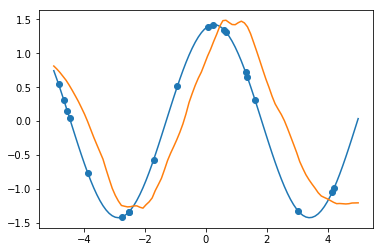

In [47]:
a = np.random.uniform(0.1, 5, size=(20,1,1))
b = np.random.uniform(0, 2*np.pi, size=(20,1,1))
X_train = np.random.uniform(-5,5, size=(20,20,1))
Y_train = a * np.sin(X_train + b)
Y_val = a * np.sin(X_val + b)
feed_dict = {
    x_train: X_train,
    x_val: X_val,
    y_train: Y_train,
    y_val: Y_val,
    lr1: 1e-2,
    lr2: 1e-2    
}
y = sess.run(val_output, feed_dict=feed_dict)
plt.scatter(X_train[-1], Y_train[-1])
plt.plot(X_val[-1], Y_val[-1])
plt.plot(X_val[-1], y[-1])
plt.show()